# Favorita Sales Predictions

I will be predicting the unit sales for thousands of items sold at different Favorita stores located in Ecuador. The training data includes dates, store and item information, whether that item was being promoted, as well as the unit sales. Additional files include supplementary information that may be useful in building my models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from pyramid.arima import auto_arima
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from rpy2.robjects import r, pandas2ri
from fbprophet import Prophet

from datetime import date, timedelta
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor

pandas2ri.activate()

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Basic information on the training, test and submission data

I am going to start by exploring the data provided. I think the simplest model to apply may be some kind of ARIMA model. In this model I will only be considering sales data and not any of the other features. Anyway before I can do that, I need to first get a feel for the training data and that is what this section is for. 

In [27]:
sample_sub = pd.read_csv('datasets/sample_submission.csv')

sample_sub.head()

id  unit_sales
0  125497040           0
1  125497041           0
2  125497042           0
3  125497043           0
4  125497044           0

In [28]:
train_df = pd.read_csv('datasets/train.csv')

train_df.head(20)

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


id        date  store_nbr  item_nbr  unit_sales onpromotion
0    0  2013-01-01         25    103665         7.0         NaN
1    1  2013-01-01         25    105574         1.0         NaN
2    2  2013-01-01         25    105575         2.0         NaN
3    3  2013-01-01         25    108079         1.0         NaN
4    4  2013-01-01         25    108701         1.0         NaN
5    5  2013-01-01         25    108786         3.0         NaN
6    6  2013-01-01         25    108797         1.0         NaN
7    7  2013-01-01         25    108952         1.0         NaN
8    8  2013-01-01         25    111397        13.0         NaN
9    9  2013-01-01         25    114790         3.0         NaN
10  10  2013-01-01         25    114800         1.0         NaN
11  11  2013-01-01         25    115267         1.0         NaN
12  12  2013-01-01         25    115611         1.0         NaN
13  13  2013-01-01         25    115693         1.0         NaN
14  14  2013-01-01         25    115720         5.0         NaN
15  15  2013-01-01         25    115850         1.0         NaN
16  16  2013-01-01         25    115891         6.0         NaN
17  17  2013-01-01         25    115892        10.0         NaN
18  18  2013-01-01         25    115894         5.0         NaN
19  19  2013-01-01         25    119024         1.0         NaN

In [29]:
print("The number of entries in the training data are: %d" % len(train_df))

train_store_nbr_values = train_df.store_nbr.value_counts(dropna = False)
train_item_nbr_values = train_df.item_nbr.value_counts(dropna = False)
train_on_promo_values = train_df.onpromotion.value_counts(dropna = False)
train_date_values = train_df.date.value_counts(dropna = False)

The number of entries in the training data are: 125497040


In [30]:
print("The number of stores in the training set: %d" % len(train_store_nbr_values))
print("The number of items in the training set: %d" % len(train_item_nbr_values))
print("The first date in the training set: ", min(train_df.date))
print("The last date in the training set: ", max(train_df.date))
print("The number of unique dates in the training set: ", len(train_date_values))
print("The number of days between the first and last date: ", pd.to_datetime(max(train_df.date))-pd.to_datetime(min(train_df.date)))

The number of stores in the training set: 54
The number of items in the training set: 4036
The first date in the training set:  2013-01-01
The last date in the training set:  2017-08-15
The number of unique dates in the training set:  1684
The number of days between the first and last date:  1687 days 00:00:00


In [31]:
test_df = pd.read_csv('datasets/test.csv')

test_df.head(20)

id        date  store_nbr  item_nbr  onpromotion
0   125497040  2017-08-16          1     96995        False
1   125497041  2017-08-16          1     99197        False
2   125497042  2017-08-16          1    103501        False
3   125497043  2017-08-16          1    103520        False
4   125497044  2017-08-16          1    103665        False
5   125497045  2017-08-16          1    105574        False
6   125497046  2017-08-16          1    105575        False
7   125497047  2017-08-16          1    105576        False
8   125497048  2017-08-16          1    105577        False
9   125497049  2017-08-16          1    105693        False
10  125497050  2017-08-16          1    105737        False
11  125497051  2017-08-16          1    105857        False
12  125497052  2017-08-16          1    106716        False
13  125497053  2017-08-16          1    108079        False
14  125497054  2017-08-16          1    108634        False
15  125497055  2017-08-16          1    108696        False
16  125497056  2017-08-16          1    108698        False
17  125497057  2017-08-16          1    108701         True
18  125497058  2017-08-16          1    108786        False
19  125497059  2017-08-16          1    108797         True

In [32]:
print("The number of entries in the test data are: %d" % len(test_df))

test_store_nbr_values = test_df.store_nbr.value_counts(dropna = False)
test_item_nbr_values = test_df.item_nbr.value_counts(dropna = False)
test_on_promo_values = test_df.onpromotion.value_counts(dropna = False)
test_date_values = test_df.date.value_counts(dropna = False)


The number of entries in the test data are: 3370464


In [33]:
print("The number of stores in the test set: %d" % len(test_store_nbr_values))
print("The number of items in the test set: %d" % len(test_item_nbr_values))
print("The first date in the test set: ", min(test_df.date))
print("The last date in the test set: ", max(test_df.date))
print("The number of unique dates in the test set: ", len(test_date_values))
print("The number of days between the first and last date: ", pd.to_datetime(max(test_df.date))-pd.to_datetime(min(test_df.date)))

The number of stores in the test set: 54
The number of items in the test set: 3901
The first date in the test set:  2017-08-16
The last date in the test set:  2017-08-31
The number of unique dates in the test set:  16
The number of days between the first and last date:  15 days 00:00:00


I've just obtained some basic information about the datasets. There are about 125 million rows in the training dataset and another 3.4 million rows in the test set. There may not be a perfect overlap between items in the training set and test set - the training set has 4036 items but the test set has just 3901. It isn't clear at this point whether all items in the test set are in the training set, however, the competition guidelines seem to indicate that this won't be the case. 
The task is to compute prediction for day to day unit sales for each of the items in the test set for a period of 16 days from the 16th of August 2017 to the 31st of August 2017. To do this I've got training data that goes back all the way to 1st Jan 2013 and carries on till the 15th of August 2017. 



## Exploring sales of a couple of items 

There is no way I can plot the sales over time for all 4036 items in the training data. However, to start I will randomly pick a couple of items and plot the sales over time. I'm doing this to see if I can spot any trends or seasonal behaviors. This may also give me a sense for how dependent future values are on past values and whether the other features account for a lot of behavior in sales or a little. 

In [34]:
train_df['date'] = pd.to_datetime(train_df['date'])

Lets pick a couple of random items to analyze ...

In [35]:
random_items = train_df.item_nbr.sample(n=20, random_state=0)

random_items = random_items.tolist()

Important question: Is it possible to have more than 1 sales reading per day ? Or are the sales of each item aggregated on a daily basis ?


In [36]:
item0_df = train_df[train_df.item_nbr == random_items[0]]

print("The number of rows in the data for item0 are: %d" % len(item0_df))
print("The number of unique dates in the data are: %d" % len(item0_df.date.value_counts()))

item0_df.head(10)

The number of rows in the data for item0 are: 69734
The number of unique dates in the data are: 1683


id       date  store_nbr  item_nbr  unit_sales onpromotion
99        99 2013-01-01         25    275823         1.0         NaN
770      770 2013-01-02          1    275823         4.0         NaN
4101    4101 2013-01-02          4    275823         1.0         NaN
5142    5142 2013-01-02          5    275823         9.0         NaN
6182    6182 2013-01-02          6    275823         3.0         NaN
7308    7308 2013-01-02          7    275823         1.0         NaN
8397    8397 2013-01-02          8    275823         1.0         NaN
9572    9572 2013-01-02          9    275823        21.0         NaN
10539  10539 2013-01-02         10    275823         4.0         NaN
11264  11264 2013-01-02         11    275823         8.0         NaN

Clearly the sales of each item is not aggregated on a daily basis because there are multiple stores.
So the new question: Is it possible to have more than 1 sales reading per day per store ? Or are the sales of each item aggregated on a daily basis for each store ?

In [37]:
for i in range(1,55):
    item0_store = item0_df[item0_df.store_nbr == i]
    print("The number of rows in the data for item0 in store ", i , " are: ", len(item0_store))
    print("The number of unique dates in the data for store ", i , "are: ", len(item0_store.date.value_counts()))
    print("---------------------------------------------------------------------------")

The number of rows in the data for item0 in store  1  are:  751
The number of unique dates in the data for store  1 are:  751
---------------------------------------------------------------------------
The number of rows in the data for item0 in store  2  are:  1221
The number of unique dates in the data for store  2 are:  1221
---------------------------------------------------------------------------
The number of rows in the data for item0 in store  3  are:  1209
The number of unique dates in the data for store  3 are:  1209
---------------------------------------------------------------------------
The number of rows in the data for item0 in store  4  are:  1027
The number of unique dates in the data for store  4 are:  1027
---------------------------------------------------------------------------
The number of rows in the data for item0 in store  5  are:  1597
The number of unique dates in the data for store  5 are:  1597
----------------------------------------------------------

Since the rows of each item in each store is exactly equal to the number of unique dates for each item and store, we can conclude that sales are indeed aggregated per day for each item in each store. This is an important result and has implications for how I will handle the data and conduct my analysis. (Offcourse I've only checked 1 random item - but seeing as the numbers are exactly equal for all 54 stores, I'm confident about my conclusion).

Now I will move on to plotting the unit sales of 20 random items in store 40 (I randomly chose the store).

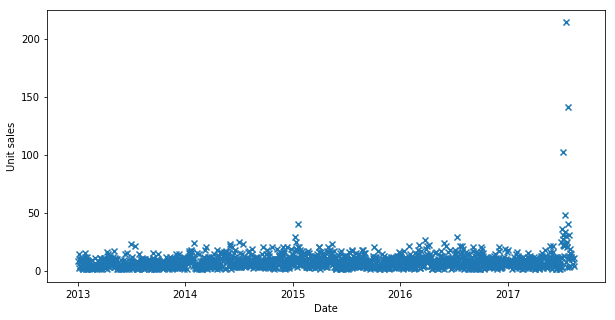

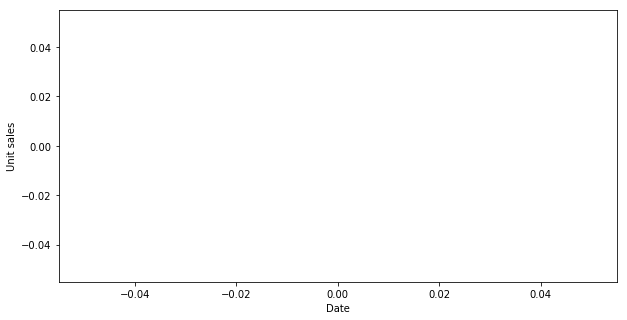

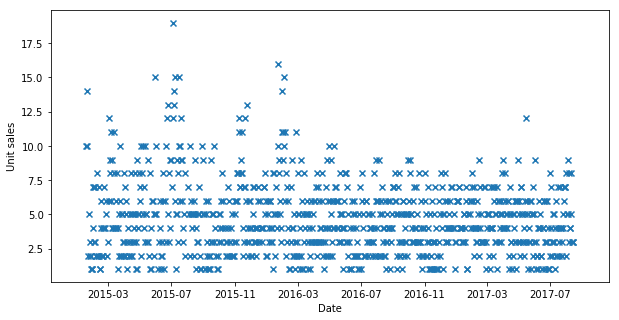

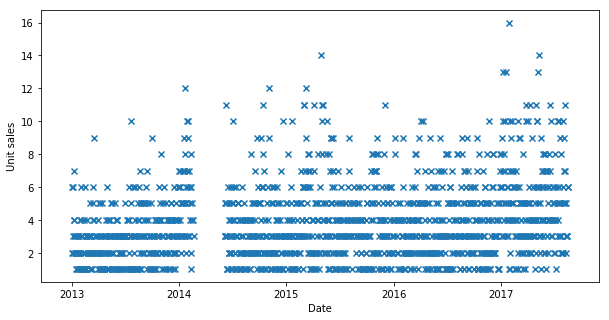

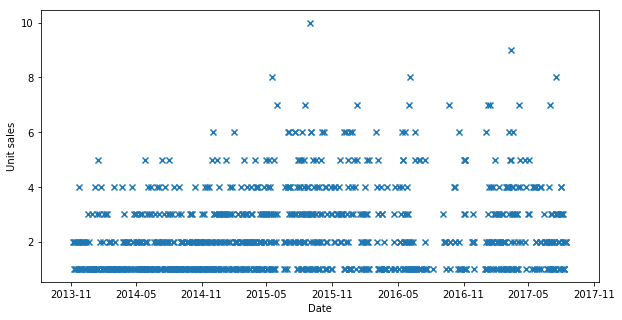

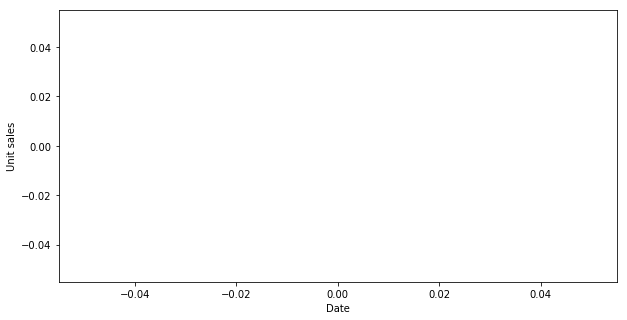

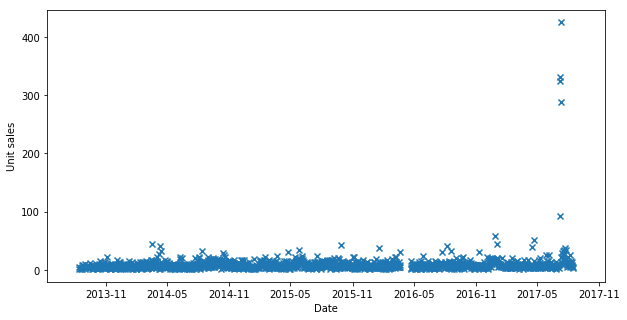

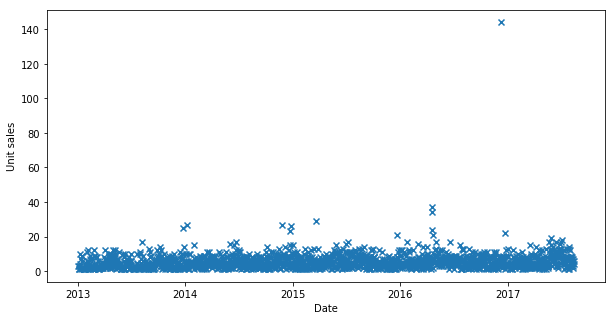

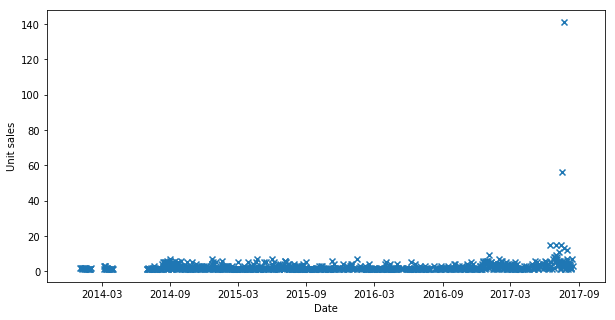

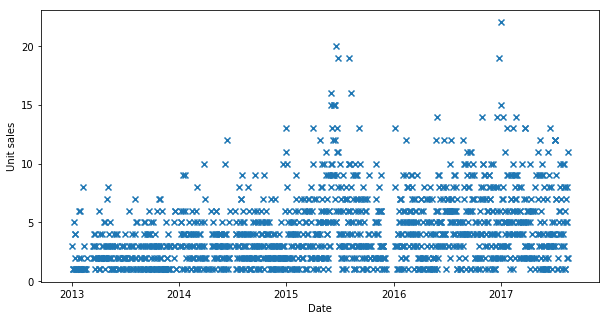

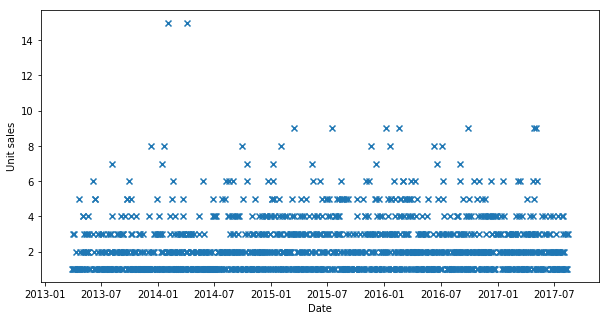

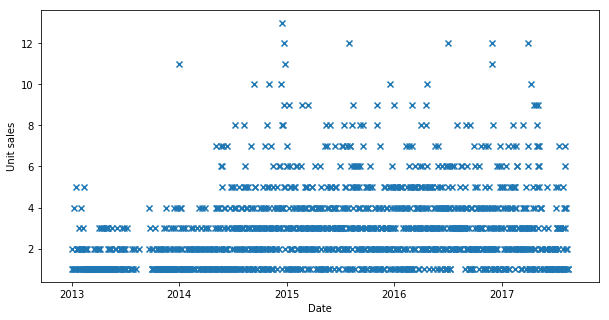

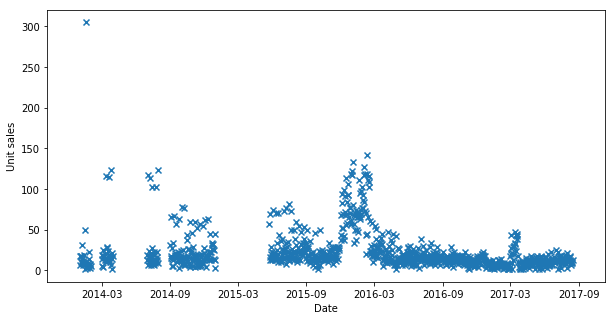

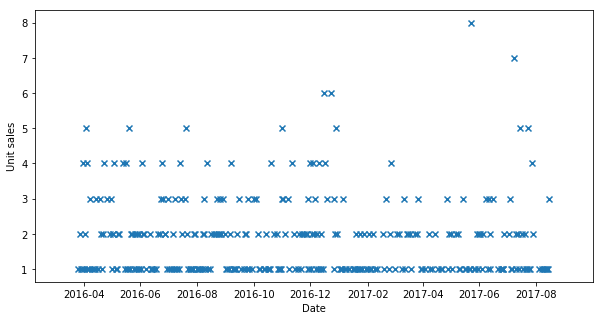

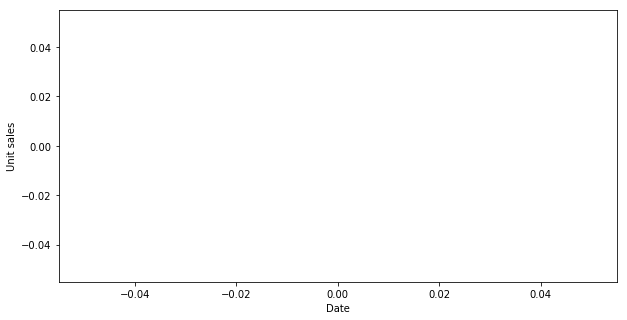

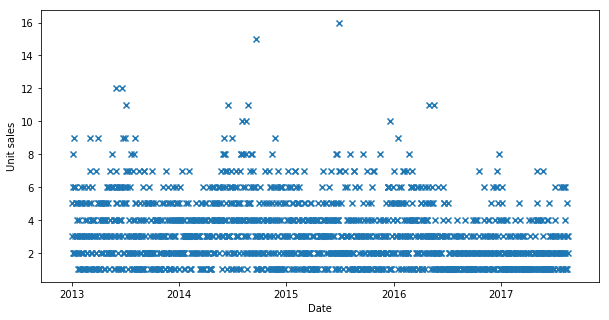

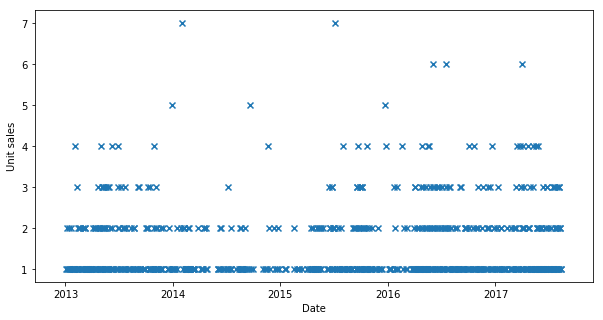

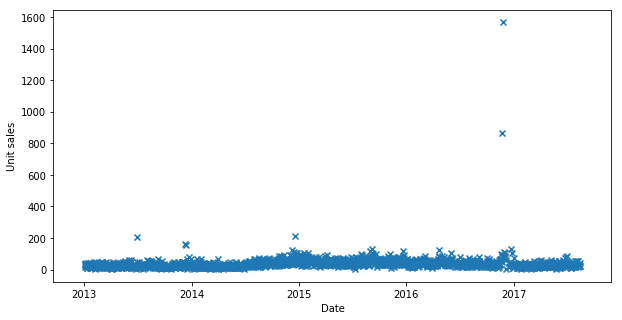

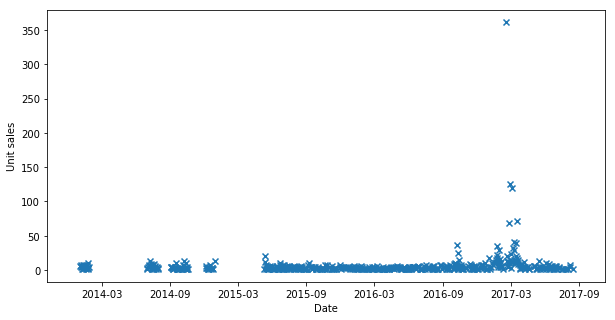

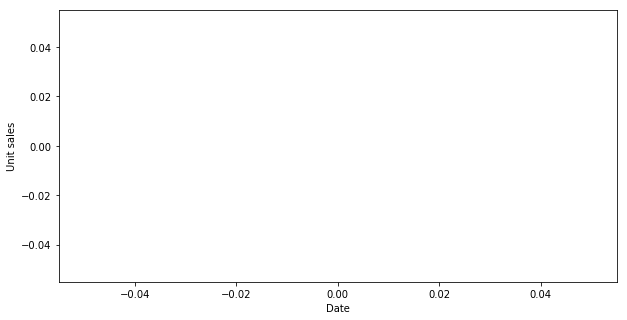

In [38]:
store40_df = train_df[train_df.store_nbr == 40]

for i in range(20):
    plt.figure(figsize=(10,5))
    itemi_df = store40_df[store40_df.item_nbr == random_items[i]]
    dates = [d.to_pydatetime() for d in itemi_df.date]
    plt.scatter(dates, y=itemi_df.unit_sales, marker='x')
    plt.ylabel('Unit sales')
    plt.xlabel('Date')

plt.show()

What is immediately apparent from the plots is that the items all have quite different sales characteristics. There are horizontal bands present on some plots because some items are sold in integer quantities e.g. 1 bag of crisps. However, other items are sold in float quantities. Some items may be popular on certain days of the year, and some items are simply not sold in that store. It is also possible that there are some missing values in the dataset - this could turn into a nuisance. It is diffcult to determine any trend or seasonality from these plots - I think day by day unit sales are just too granular for these features to become obvious. 

I can already tell that an ARIMA or ETS model by itself is not going to yield great results. Dynamic regression may yield better results - but I don't have any information (as yet) to make any real statement to this end. 

## Dealing with missing sales data

Now comes the tricky problem of handling missing sales data.

When data is missing I'm not sure whether it means that unit sales were 0 or someone just forgot to record the sales for that item that day. However, looking at some of the plots above, I think the best thing to do will be to assume that the sales were simply not recorded. This means I need to find a way to impute the missing sales data rather than just setting a bunch of zeros. I will use an arima model to impute values

The first step is to introduce a bunch of new rows for all the missing dates, and fill the unit sales for those dates with NA values.

In [84]:
# Testing interpolation with one item in one store

item_df = train_df[train_df.item_nbr == random_items[12]]
item_store_df = item_df[item_df.store_nbr == 40]

s = pd.Series(list(item_store_df.unit_sales), item_store_df.date)
NAd_sales = s.asfreq('D')

dates = NAd_sales.keys()

fr = ro.r('library(imputeTS)')

NAd_sales_R = pandas2ri.py2ri(NAd_sales)
ro.globalenv["NAd_sales_R"] = NAd_sales_R

filled_sales_R = ro.r('na.kalman(NAd_sales_R, model = "auto.arima", smooth = TRUE)')

filled_sales = pd.Series.round(pd.Series(filled_sales_R))

filled_df = pd.DataFrame({'date': pd.Series(dates), 'unit_sales': filled_sales})
filled_df.head(20)

date  unit_sales
0  2014-01-02        17.0
1  2014-01-03         7.0
2  2014-01-04        17.0
3  2014-01-05        10.0
4  2014-01-06        17.0
5  2014-01-07        31.0
6  2014-01-08        14.0
7  2014-01-09        10.0
8  2014-01-10         7.0
9  2014-01-11        11.0
10 2014-01-12         8.0
11 2014-01-13        19.0
12 2014-01-14        10.0
13 2014-01-15         9.0
14 2014-01-16        49.0
15 2014-01-17         2.0
16 2014-01-18       305.0
17 2014-01-19        10.0
18 2014-01-20         7.0
19 2014-01-21         4.0

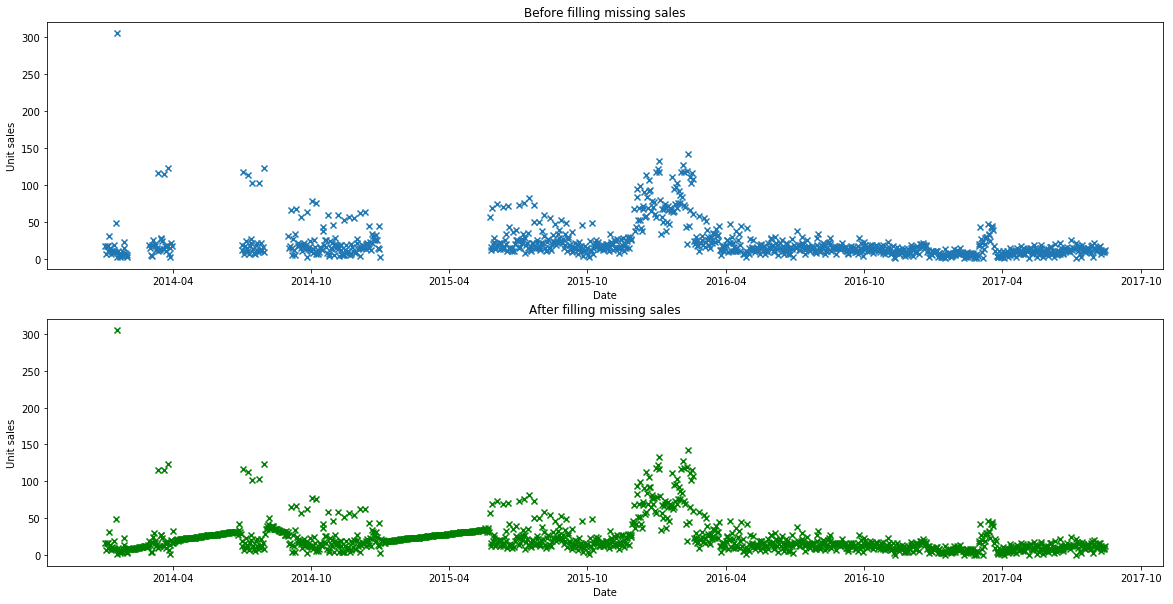

In [85]:
plt.figure(figsize=(20,10))

plt.subplot(211)
dates = [d.to_pydatetime() for d in item_store_df.date]
plt.scatter(dates, y=item_store_df.unit_sales, marker='x')
plt.title("Before filling missing sales")
plt.ylabel('Unit sales')
plt.xlabel('Date')

plt.subplot(212)
dates = [d.to_pydatetime() for d in filled_df.date]
plt.scatter(dates, y=filled_df.unit_sales, marker='x', color='g')
plt.title("After filling missing sales")
plt.ylabel('Unit sales')
plt.xlabel('Date')

plt.show()

In [94]:
def sales_filler(df, item_nbr, store_nbr):
    s = pd.Series(list(df.unit_sales), df.date)
    NAd_sales = s.asfreq('D')
    
    dates = NAd_sales.keys()

    fr = ro.r('library(imputeTS)')

    NAd_sales_R = pandas2ri.py2ri(NAd_sales)
    ro.globalenv["NAd_sales_R"] = NAd_sales_R

    filled_sales_R = ro.r('na.kalman(NAd_sales_R, model = "auto.arima", smooth = TRUE)')

    filled_sales = pd.Series.round(pd.Series(filled_sales_R))

    filled_df = pd.DataFrame({'date': pd.Series(dates), 'unit_sales': filled_sales})
    
    merged_df = filled_df.merge(df.drop(['unit_sales'], axis=1), on='date', how='left')
    merged_df['store_nbr'] = merged_df.store_nbr.fillna(store_nbr)
    merged_df['item_nbr'] = merged_df.item_nbr.fillna(item_nbr)
    
    return merged_df


item_df = train_df[train_df.item_nbr == random_items[0]]
item_store_df = item_df[item_df.store_nbr == 40]
sales_filler(item_store_df, random_items[0], 40)


date  unit_sales           id  store_nbr  item_nbr onpromotion
0    2013-01-02         8.0      30251.0       40.0  275823.0         NaN
1    2013-01-03        14.0      70760.0       40.0  275823.0         NaN
2    2013-01-04         2.0     110603.0       40.0  275823.0         NaN
3    2013-01-05         9.0          NaN       40.0  275823.0         NaN
4    2013-01-06         4.0     194522.0       40.0  275823.0         NaN
5    2013-01-07         4.0     234632.0       40.0  275823.0         NaN
6    2013-01-08         9.0     273827.0       40.0  275823.0         NaN
7    2013-01-09         9.0     312779.0       40.0  275823.0         NaN
8    2013-01-10         3.0     351477.0       40.0  275823.0         NaN
9    2013-01-11         7.0     390249.0       40.0  275823.0         NaN
10   2013-01-12        10.0     431817.0       40.0  275823.0         NaN
11   2013-01-13        11.0     473775.0       40.0  275823.0         NaN
12   2013-01-14         9.0     514126.0       40.0  275823.0         NaN
13   2013-01-15         8.0     553735.0       40.0  275823.0         NaN
14   2013-01-16         2.0     593506.0       40.0  275823.0         NaN
15   2013-01-17         1.0     632992.0       40.0  275823.0         NaN
16   2013-01-18         2.0     672497.0       40.0  275823.0         NaN
17   2013-01-19         1.0     715093.0       40.0  275823.0         NaN
18   2013-01-20         5.0     757608.0       40.0  275823.0         NaN
19   2013-01-21         5.0     798452.0       40.0  275823.0         NaN
20   2013-01-22         8.0     838211.0       40.0  275823.0         NaN
21   2013-01-23        15.0     877368.0       40.0  275823.0         NaN
22   2013-01-24         4.0     916264.0       40.0  275823.0         NaN
23   2013-01-25         8.0     955676.0       40.0  275823.0         NaN
24   2013-01-26        12.0     998113.0       40.0  275823.0         NaN
25   2013-01-27         1.0    1040397.0       40.0  275823.0         NaN
26   2013-01-28         1.0    1081066.0       40.0  275823.0         NaN
27   2013-01-29         3.0    1120639.0       40.0  275823.0         NaN
28   2013-01-30         3.0    1160322.0       40.0  275823.0         NaN
29   2013-01-31         9.0    1200324.0       40.0  275823.0         NaN
...         ...         ...          ...        ...       ...         ...
1657 2017-07-17        30.0  122431196.0       40.0  275823.0        True
1658 2017-07-18        23.0  122533678.0       40.0  275823.0        True
1659 2017-07-19         7.0  122634195.0       40.0  275823.0        True
1660 2017-07-20       214.0  122735208.0       40.0  275823.0        True
1661 2017-07-21         3.0  122836006.0       40.0  275823.0        True
1662 2017-07-22        25.0  122943690.0       40.0  275823.0        True
1663 2017-07-23        20.0  123053539.0       40.0  275823.0        True
1664 2017-07-24       141.0  123160988.0       40.0  275823.0        True
1665 2017-07-25        40.0  123263581.0       40.0  275823.0        True
1666 2017-07-26        13.0  123363293.0       40.0  275823.0        True
1667 2017-07-27        10.0  123461713.0       40.0  275823.0       False
1668 2017-07-28        31.0  123562709.0       40.0  275823.0       False
1669 2017-07-29        11.0  123671929.0       40.0  275823.0       False
1670 2017-07-30         3.0  123783082.0       40.0  275823.0       False
1671 2017-07-31         4.0  123891830.0       40.0  275823.0       False
1672 2017-08-01        19.0  124000542.0       40.0  275823.0       False
1673 2017-08-02        15.0  124108077.0       40.0  275823.0       False
1674 2017-08-03        12.0  124211903.0       40.0  275823.0       False
1675 2017-08-04        12.0  124315057.0       40.0  275823.0       False
1676 2017-08-05        14.0  124424117.0       40.0  275823.0       False
1677 2017-08-06        11.0          NaN       40.0  275823.0         NaN
1678 2017-08-07        11.0          NaN       40.0  275823.0         NaN
1679 2017-08-08

## Trying out ARIMA models on the data

I'm going to try fitting ARIMA models to items in the stores. This offcourse ignores a lot of the data I've got. However, it should make for a decent starting point. Let me start by just picking a random item and random store and fitting an ARIMA model to that courtesy of the Pyramid library.
In order to evaluate the model I'm going to split the training data into a training set and cross-validation set. The cross-val set is simply going to consist of the last 61 sales entries in the training data (reasonable small but I've done this purposely because the model only needs to predict something like 15 days ahead so there's no point in having a long duration cross-val). I want to end up with some good error metrics against which I can compare future models, and for that, this step is necessary.

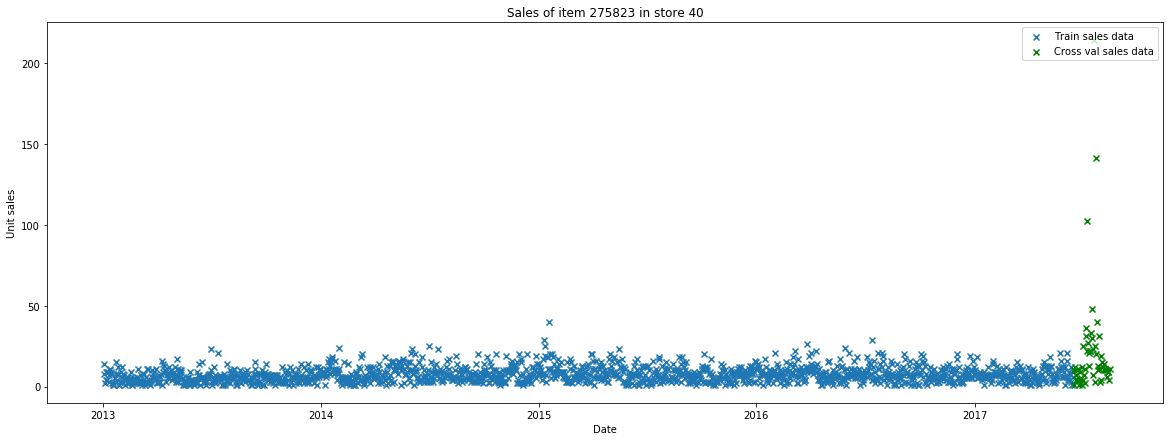

In [119]:
def item_store_dates_train_cval(item_nbr, store_nbr):
    item_df = train_df[train_df.item_nbr == item_nbr]
    item_store_df = item_df[item_df.store_nbr == store_nbr]
    
    item_store_df = sales_filler(item_store_df, item_nbr, store_nbr)
    item_store_train = item_store_df.iloc[:-61,:]
    item_store_cval = item_store_df.iloc[-61:,:]
    
    dates_train = [d.to_pydatetime() for d in item_store_train.date]
    dates_cval = [d.to_pydatetime() for d in item_store_cval.date]
    
    return dates_train, dates_cval, item_store_train, item_store_cval

dates_train, dates_cval, item0_store40_train, item0_store40_cval = item_store_dates_train_cval(random_items[0], 40)

plt.figure(figsize=(20,7))
plt.scatter(dates_train, y=item0_store40_train.unit_sales, marker='x')
plt.scatter(dates_cval, y=item0_store40_cval.unit_sales, marker='x', color='g')
plt.title("Sales of item " + str(random_items[0]) + " in store 40")
plt.ylabel('Unit sales')
plt.xlabel('Date')
plt.legend(('Train sales data', 'Cross val sales data'), loc='upper right')
plt.show()

I'm going to assume a seasonality (m) of 7 ie. that a weekly repeating pattern may be present

In [120]:
stepwise_fit = auto_arima(item0_store40_train.unit_sales, start_p=1, start_q=1, max_p=3, max_q=3, m=7,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=9485.083, BIC=9512.052, Fit time=5.692 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=10632.848, BIC=10654.424, Fit time=1.272 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=9516.450, BIC=9538.025, Fit time=3.481 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=9485.935, BIC=9518.298, Fit time=7.319 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=10495.933, BIC=10517.509, Fit time=0.873 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=9483.318, BIC=9515.681, Fit time=11.225 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=9515.142, BIC=9542.111, Fit time=9.021 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=9487.969, BIC=9525.727, Fit time=12.294 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1626
Model:             SARIMAX(1, 1, 1)x(0, 1, 2, 7)   Log Likelihood               -4735.659
Date:                           Sat, 06 Jan 2018   AIC                           9483.318
Time:                                   15:35:23   BIC                           9515.681
Sample:                                        0   HQIC                          9495.326
                                          - 1626                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.223e-05   5.43e-05     -0.410      0.682      -0.000    8.42e-05
ar.L1          0.1633      0.024      6.684      0.000       0.115       0.211
ma.L1         -0.9722      0.006   -154.986      0.000      -0.984      -0.960
ma.S.L7       -0.9734      0.156     -6.258      0.000      -1.278      -0.669
ma.S.L14      -0.0262      0.026     -1.025      0.305      -0.076       0.024
sigma2        19.8724      3.104      6.402      0.000      13.788      25.956
===================================================================================
Ljung-Box (Q):                       41.63   Jarque-Bera (JB):               382.14
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                             0.89
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

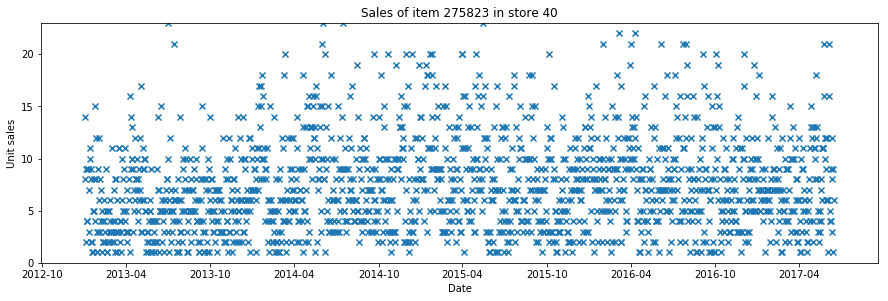

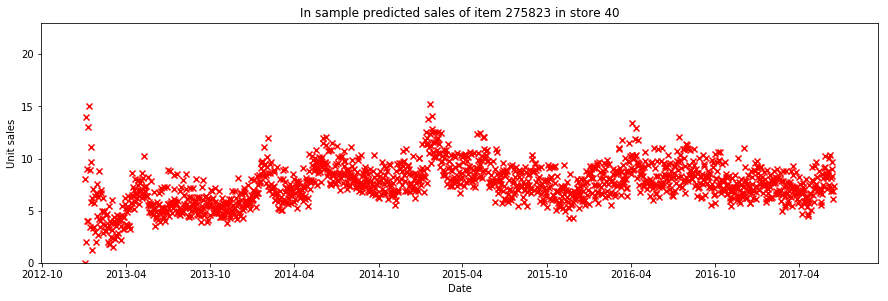

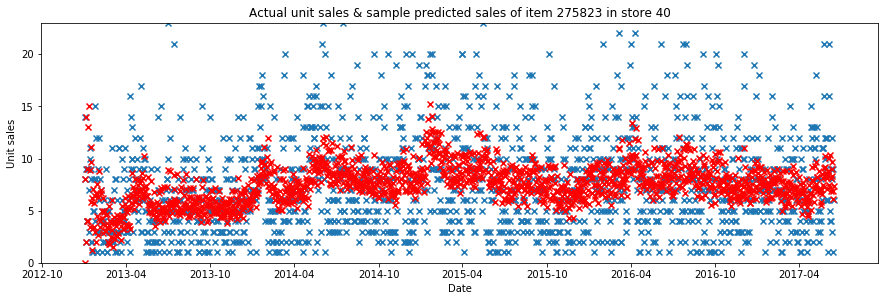

In [121]:
item0_store40_in_sample_preds = stepwise_fit.predict_in_sample()

def plot_actual_and_pred_sales(item_id, dates, actual_sales, pred_sales):
    plt.figure(figsize=(15,15))
    plt.subplot(311)
    plt.scatter(dates, y=actual_sales, marker='x')
    plt.title("Sales of item " + str(item_id) + " in store 40")
    plt.ylim([0,23])
    plt.ylabel('Unit sales')
    plt.xlabel('Date')
    plt.show()

    plt.figure(figsize=(15,15))
    plt.subplot(312)
    plt.scatter(dates, y=pred_sales, marker='x', color='r')
    plt.title("In sample predicted sales of item " + str(item_id) + " in store 40")
    plt.ylim([0,23])
    plt.ylabel('Unit sales')
    plt.xlabel('Date')
    plt.show()

    plt.figure(figsize=(15,15))
    plt.subplot(313)
    plt.scatter(dates, y=actual_sales, marker='x')
    plt.scatter(dates, y=pred_sales, marker='x', color='r')
    plt.title("Actual unit sales & sample predicted sales of item " + str(item_id) + " in store 40")
    plt.ylim([0,23])
    plt.ylabel('Unit sales')
    plt.xlabel('Date')
    plt.show()
    
plot_actual_and_pred_sales(random_items[0], dates_train, item0_store40_train.unit_sales, item0_store40_in_sample_preds)


The ARIMA model appears to have done a decent job of capturing the general trend of the series, however, it clearly isn't capturing much of the variablity in the day to day sales. Offcourse this is just the result from 1 item in 1 store ! This same model has to be run for each item in the 54 stores ie. 4036 * 54 = 217,944 times. If each run takes about 30 seconds then it will take about 1816.2 hours to run ! Or 76 days ! This just won't do ! This has just flagged that I'm going to have to take running time into consideration when doing my analysis and developing my models. 

Now I will plot the results of using this model to forecast the values for the cross-validation dates. I will then move onto model evaluation using a more formal metric.

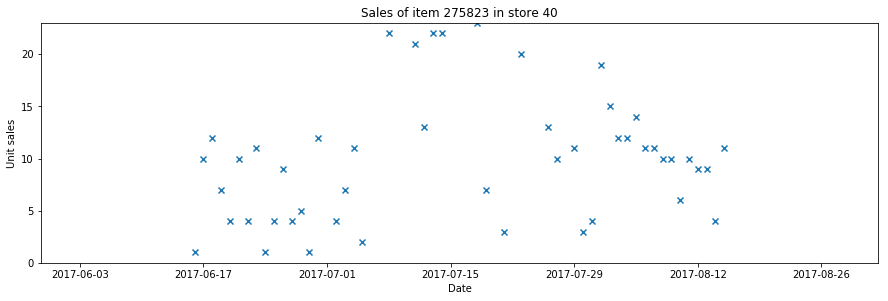

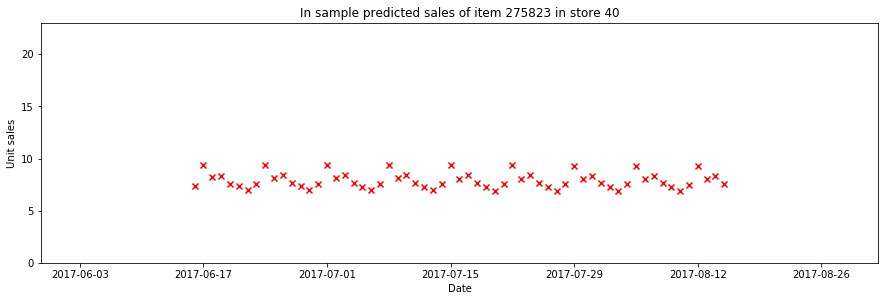

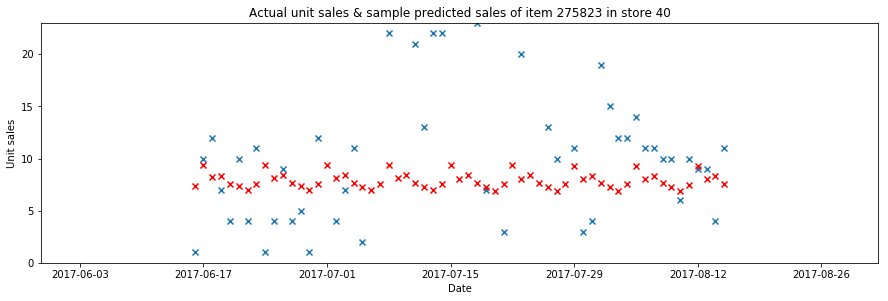

In [98]:
next_61 = stepwise_fit.predict(n_periods=61)

plot_actual_and_pred_sales(random_items[0], dates_cval, item0_store40_cval.unit_sales, next_61)

Now using RMSE as the evaluation metric ...

In [99]:
# Training set error

def rmse(actual, predicted):
    return np.sqrt((1/len(actual))*np.sum((predicted - actual)**2))
    
train_rmse = rmse(item0_store40_train.unit_sales, item0_store40_in_sample_preds)
cval_rmse = rmse(item0_store40_cval.unit_sales, next_61)

print("The RMSE for the training set: %f" % train_rmse)
print("The RMSE for the cross validation set: %f" % cval_rmse)

The RMSE for the training set: 4.529902
The RMSE for the cross validation set: 35.681626


Now I would like to run similar analyses to the one above on a few more item-store combinations. I will then use these results to establish a baseline to compare future models against.
Note that I'm not running my models on the whole dataset because that would just take too long and slow down the process of iterating towards better models. 

Item ID:  275823


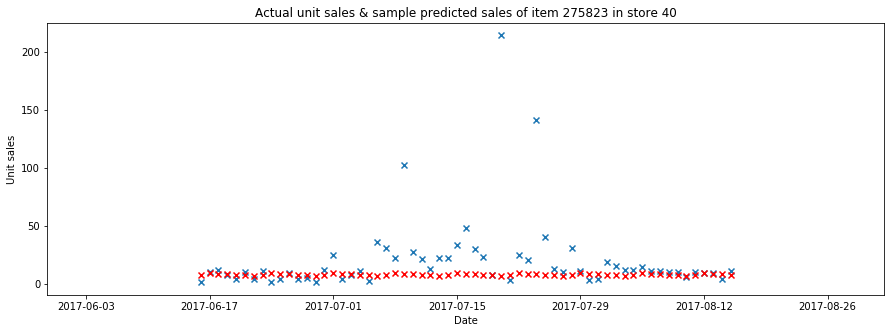


-------------------------------------------------------------

Item ID:  980041

-------------------------------------------------------------

Item ID:  1400331


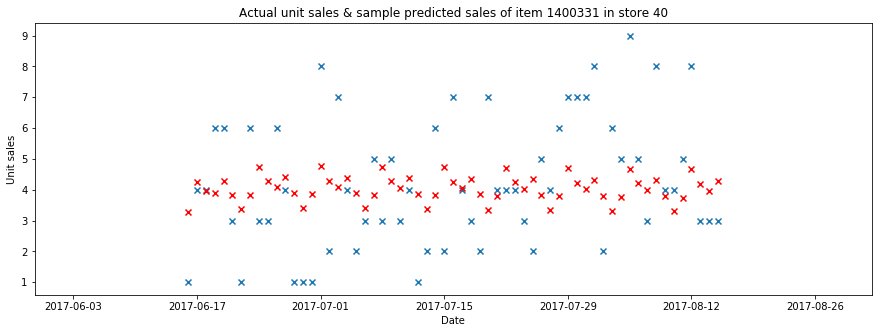


-------------------------------------------------------------

Item ID:  551893


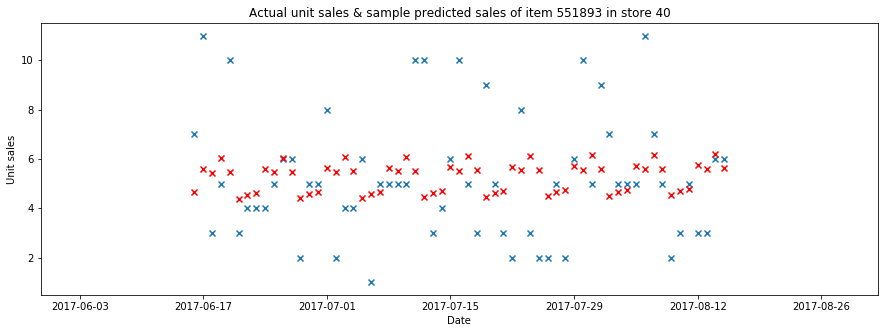


-------------------------------------------------------------

Item ID:  1230418


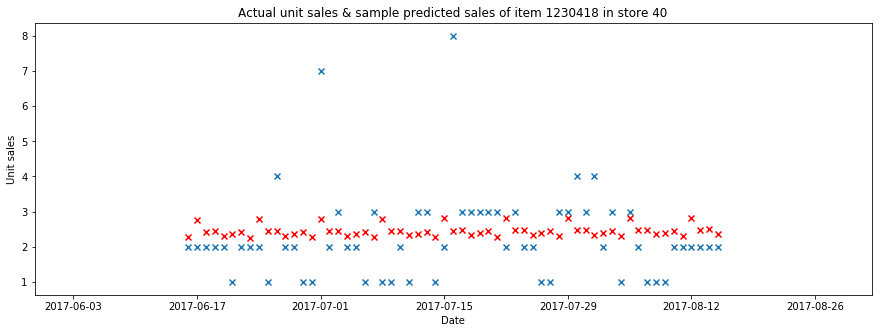


-------------------------------------------------------------

Item ID:  1354719

-------------------------------------------------------------

Item ID:  1165989


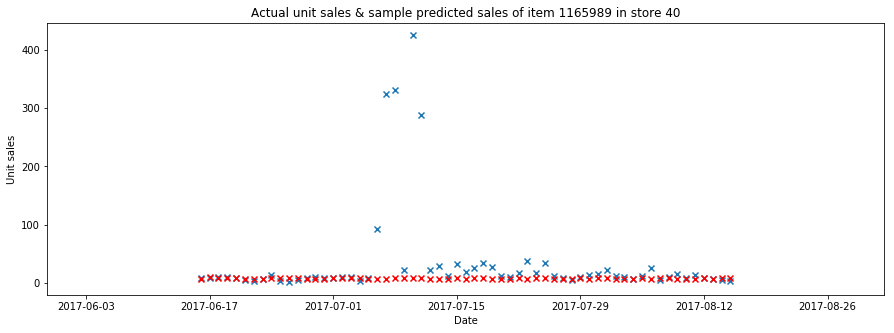


-------------------------------------------------------------

Item ID:  872310


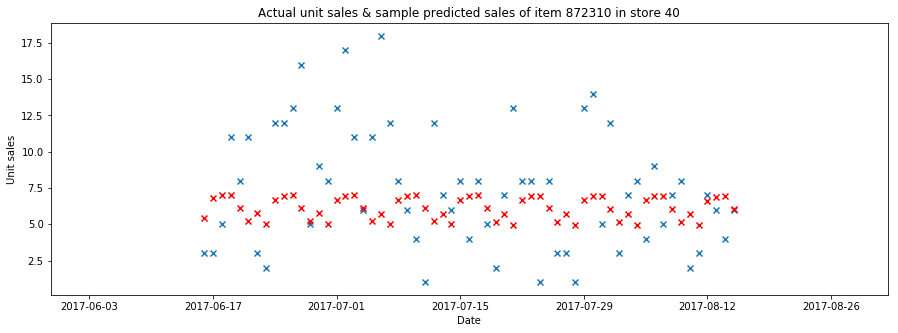


-------------------------------------------------------------

Item ID:  1324670


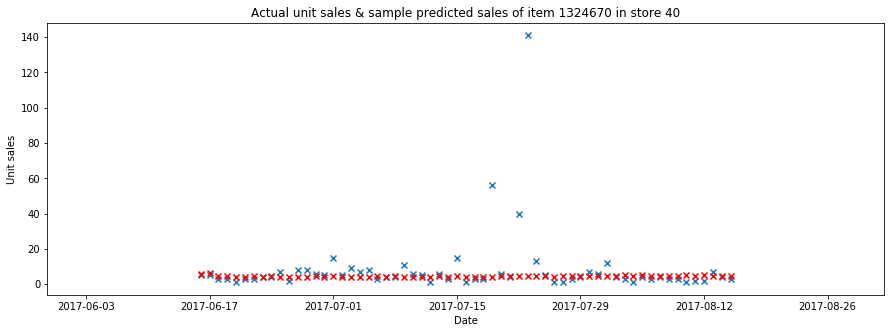


-------------------------------------------------------------

Item ID:  1091370


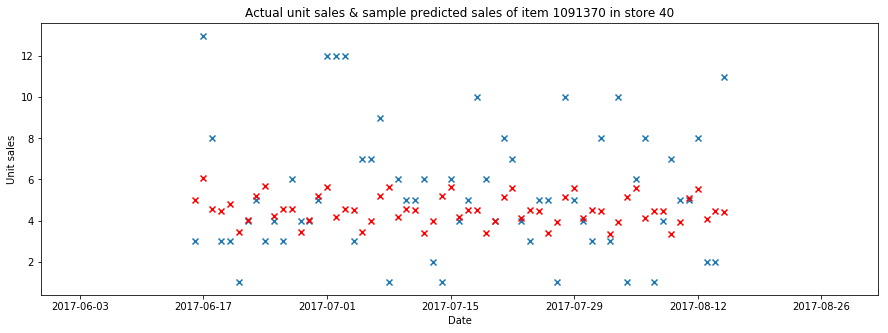


-------------------------------------------------------------

Item ID:  1119216


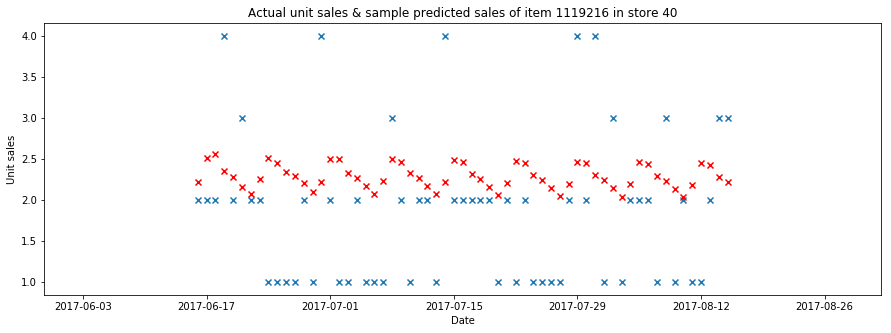


-------------------------------------------------------------

Item ID:  683721


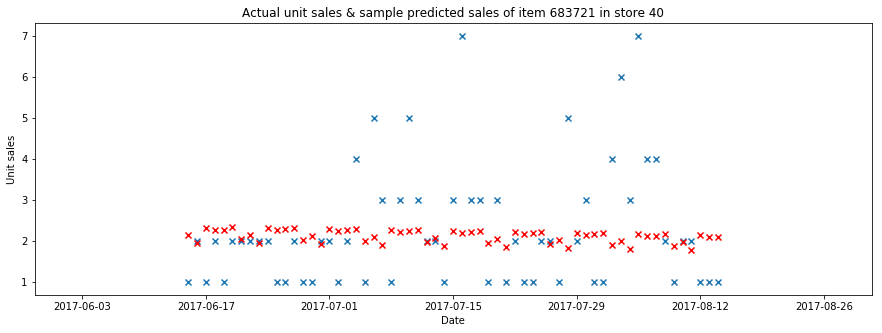


-------------------------------------------------------------

Item ID:  1464092


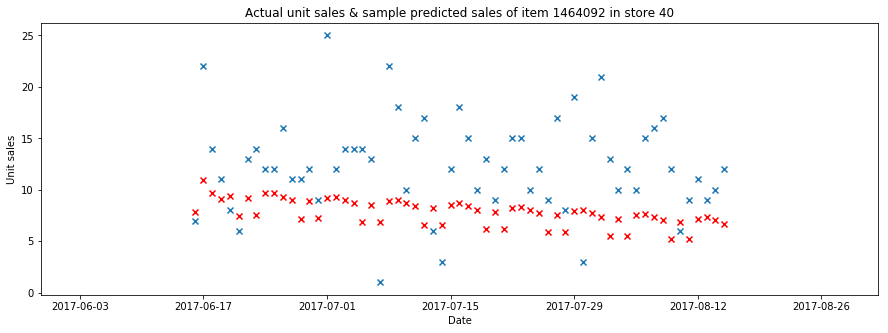


-------------------------------------------------------------

Item ID:  418024


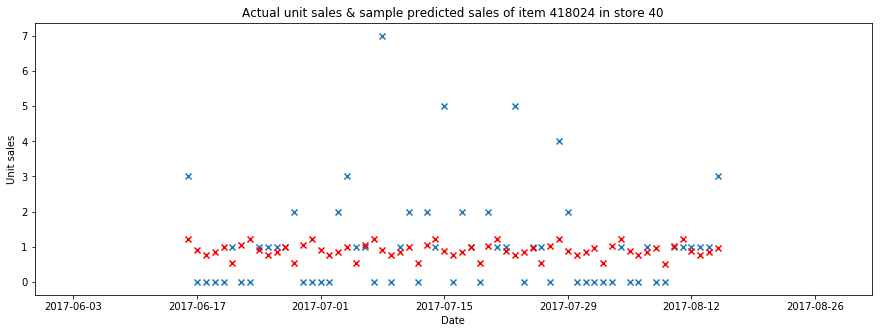


-------------------------------------------------------------

Item ID:  587156

-------------------------------------------------------------

Item ID:  671062


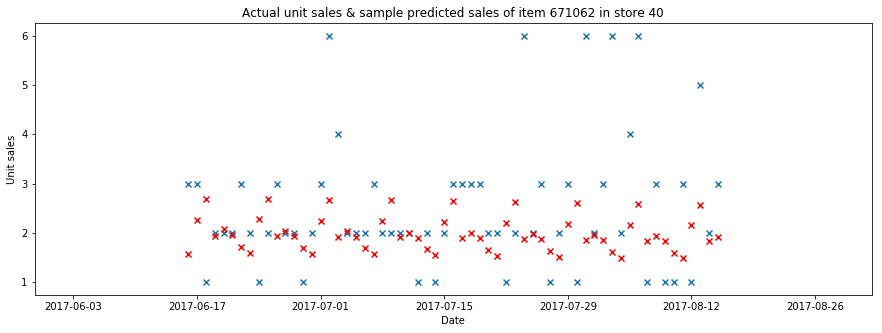


-------------------------------------------------------------

Item ID:  770511


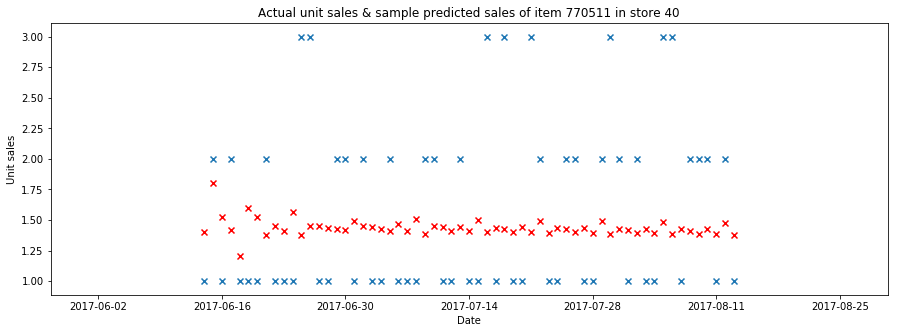


-------------------------------------------------------------

Item ID:  876663


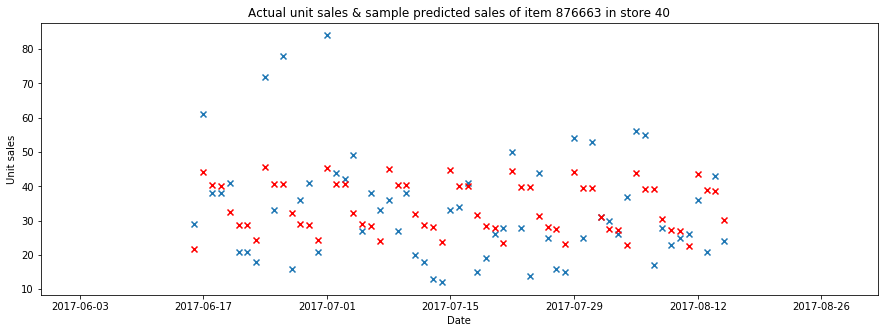


-------------------------------------------------------------

Item ID:  1463510


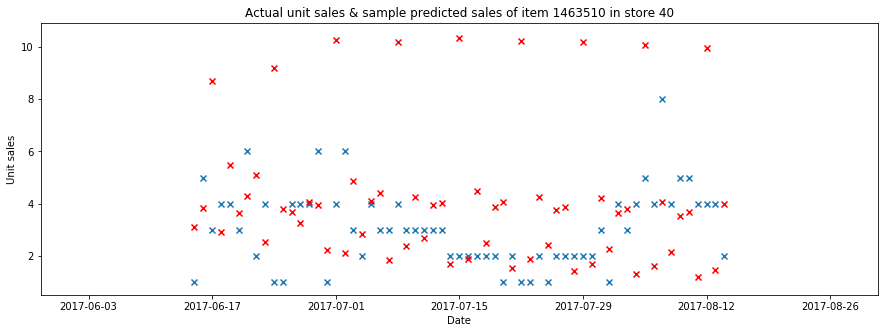


-------------------------------------------------------------

Item ID:  849136

-------------------------------------------------------------



In [100]:
def plot_actual_preds_together(item_id, dates, actual_sales, pred_sales):
    plt.figure(figsize=(15,5))
    plt.scatter(dates, y=actual_sales, marker='x')
    plt.scatter(dates, y=pred_sales, marker='x', color='r')
    plt.title("Actual unit sales & sample predicted sales of item " + str(item_id) + " in store 40")
    plt.ylabel('Unit sales')
    plt.xlabel('Date')
    plt.show()

train_rmses = [None]*20
cval_rmses = [None]*20


for i in range(len(random_items)):
    print("Item ID: ", random_items[i])
    dates_train, dates_cval, item_store_train, item_store_cval = item_store_dates_train_cval(random_items[i], 40)
    if(len(item_store_train) > 0):
   
        stepwise_fit = auto_arima(item_store_train.unit_sales, start_p=1, start_q=1, max_p=3, max_q=3, m=7,
                          start_P=0, seasonal=True, d=1, D=1, trace=False,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise
        item_store_in_sample_preds = stepwise_fit.predict_in_sample()
        next_61 = stepwise_fit.predict(n_periods=61)
        plot_actual_preds_together(random_items[i], dates_cval, item_store_cval.unit_sales, next_61)
        train_rmses[i] = rmse(item_store_train.unit_sales, item_store_in_sample_preds)
        cval_rmses[i] = rmse(item_store_cval.unit_sales, next_61)
        
    print("")
    print("-------------------------------------------------------------")
    print("")


In [101]:
train_rmses = [x for x in train_rmses if x is not None]
cval_rmses = [x for x in cval_rmses if x is not None]

print("Median Training RMSE: ", np.median(train_rmses))
print("Median Cross Validation RMSE: ", np.median(cval_rmses))
print()
print("Mean Training RMSE: ", np.mean(train_rmses))
print("Mean Cross Validation RMSE: ", np.mean(cval_rmses))

Median Training RMSE:  2.23926216017
Median Cross Validation RMSE:  2.79061267781

Mean Training RMSE:  6.34920486993
Mean Cross Validation RMSE:  11.526317036


The RMSE values above provide me with a baseline error against which I can compare future models. They aren't ideal because they are based on a sample of the data, but it would just take too long to run these models on all the data (as we showed before). Note that a seed has been set so I can get the same sample each time this code is run. 

The next step is now to build a more complex model that includes the other features that have been provided. The running time of these models however, is still a problem - I need to think about how to deal with that !

## Dynamic regression with the onpromotion feature

The next step is to try dynamic regression using the onpromotion feature (along with the ARIMA model on the regression errors). The onpromotion feature has been chosen because it is the simplest feature to start with and intuitively it seems like it should have an effect on sales. Unfortunately, Python does not seem to have a library that can perform the dynamic regression and therefore, I'm going to have to port over the auto arima function from R using the rpy2 package.

The onpromotion field has a lot of NaN values, and for now I'm going to treat those as False values. 

In [102]:
dates_train, dates_cval, item0_store40_train, item0_store40_cval = item_store_dates_train_cval(1463510, 40)

item0_store40_train['onpromotion'] = item0_store40_train.onpromotion.fillna(False)
item0_store40_train['onpromotion'] = item0_store40_train.onpromotion.map(lambda x: 1 if x == True else 0)

item0_store40_cval['onpromotion'] = item0_store40_cval.onpromotion.fillna(False)
item0_store40_cval['onpromotion'] = item0_store40_cval.onpromotion.map(lambda x: 1 if x == True else 0)


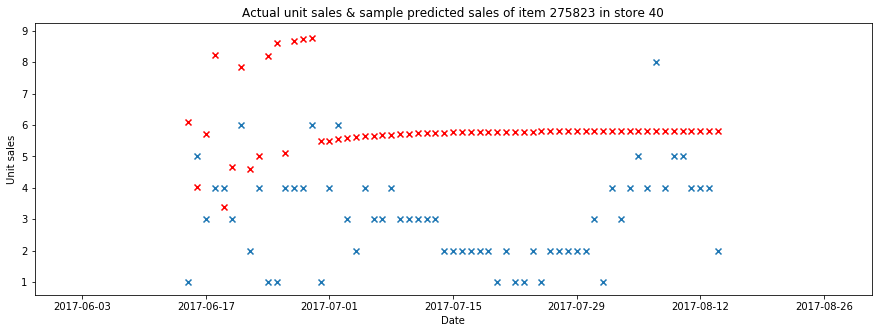

In [103]:
fr = ro.r('library(forecast)')

item0_store40_train_R = pandas2ri.py2ri(item0_store40_train)
item0_store40_cval_R = pandas2ri.py2ri(item0_store40_cval)
ro.globalenv["item0_store40_train_R"] = item0_store40_train_R
ro.globalenv["item0_store40_cval_R"] = item0_store40_cval_R

xreg_train = ro.r('item0_store40_train_R[,"onpromotion"]')
xreg_cval = ro.r('item0_store40_cval_R[,"onpromotion"]')
ro.globalenv["xreg_train"] = xreg_train
ro.globalenv["xreg_cval"] = xreg_cval

pred = ro.r(''' fit <- auto.arima(item0_store40_train_R$unit_sales, xreg=xreg_train)
                as.data.frame(forecast(fit, xreg=xreg_cval))''')

dates_cval = [d.to_pydatetime() for d in item0_store40_cval.date]

plot_actual_preds_together(random_items[0], dates_cval, item0_store40_cval.unit_sales, pred['Point Forecast'])


A few things to note:
* The ARIMA model produced by R's auto arima function is different from the ARIMA model produced by Python
* At the moment I've just tried including a single regressor i.e. onpromotion . This may not increase the predictive power much (compared to our baseline). It does however, demonstrate the way forward - now I need to try including a lot more regressors

However, before going ahead with developing a model with more regressors. Let me calculate the RMSE values so I can gauge this model's performance.

Single regressor dynamic regression model using R's auto arima
-------------------------------------------------------------
Item ID:  275823


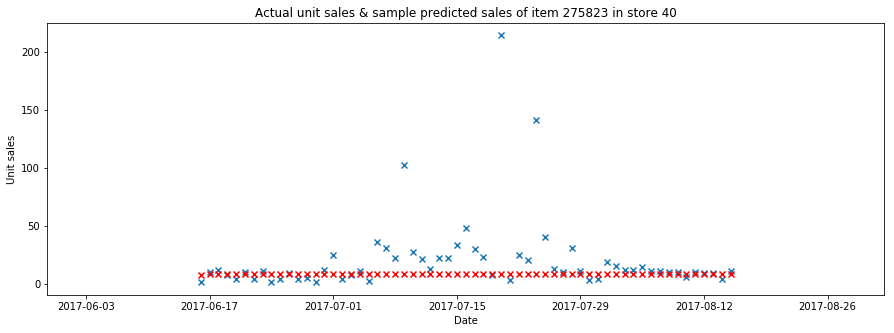


-------------------------------------------------------------

Item ID:  980041

-------------------------------------------------------------

Item ID:  1400331


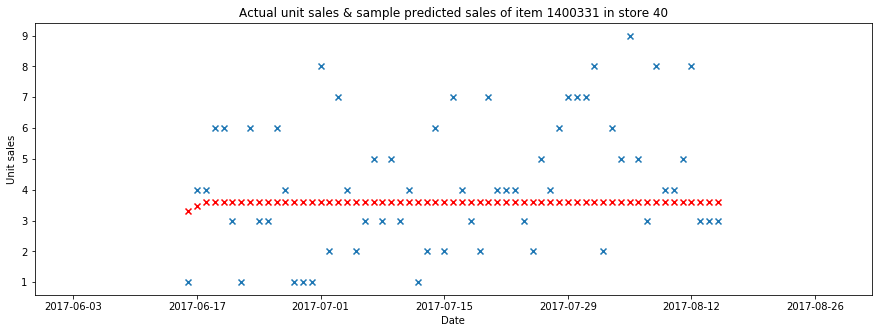


-------------------------------------------------------------

Item ID:  551893


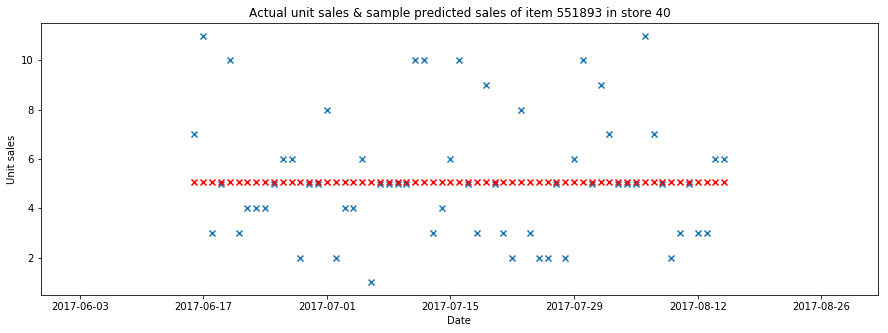


-------------------------------------------------------------

Item ID:  1230418


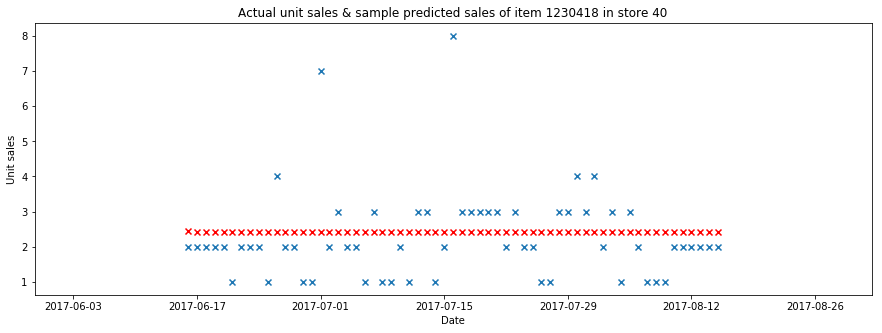


-------------------------------------------------------------

Item ID:  1354719

-------------------------------------------------------------

Item ID:  1165989


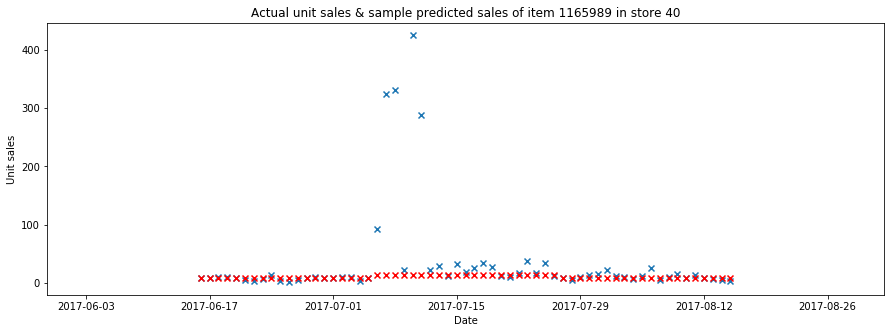


-------------------------------------------------------------

Item ID:  872310


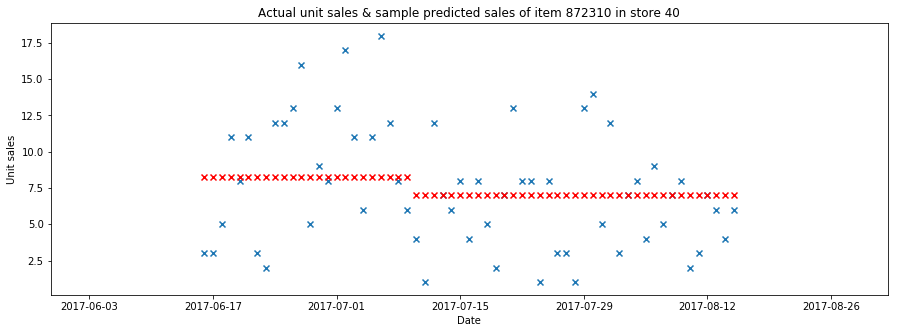


-------------------------------------------------------------

Item ID:  1324670


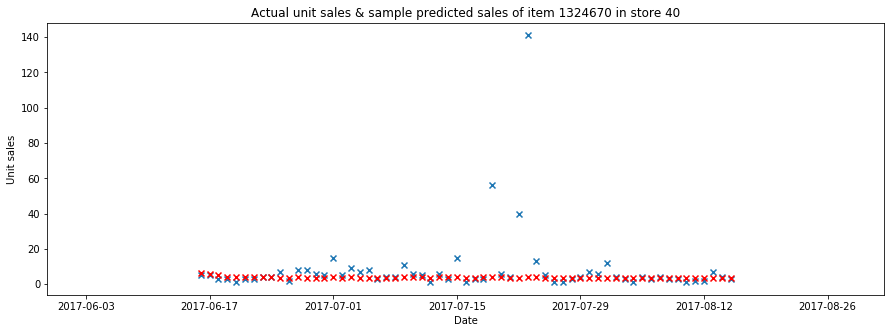


-------------------------------------------------------------

Item ID:  1091370


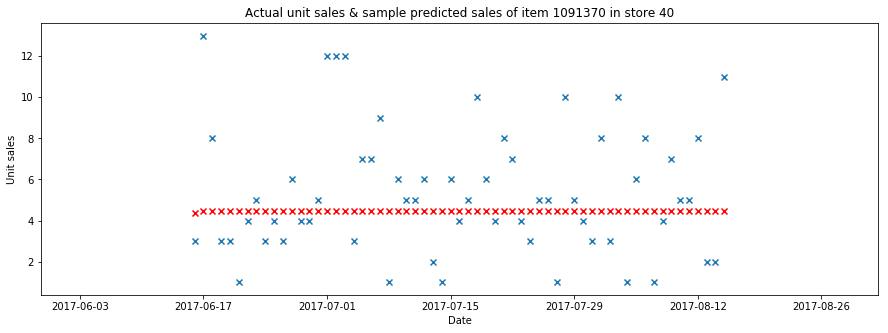


-------------------------------------------------------------

Item ID:  1119216


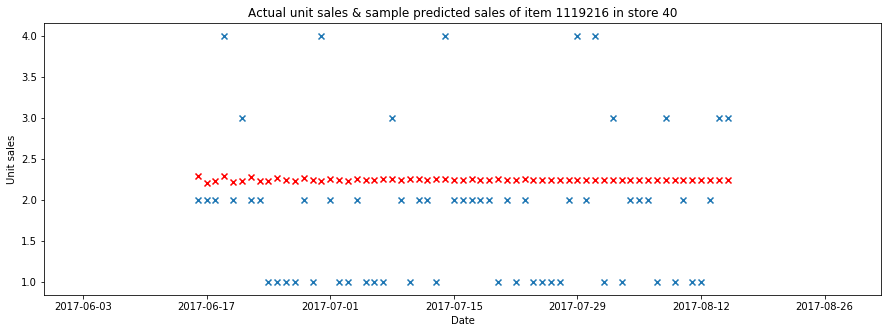


-------------------------------------------------------------

Item ID:  683721


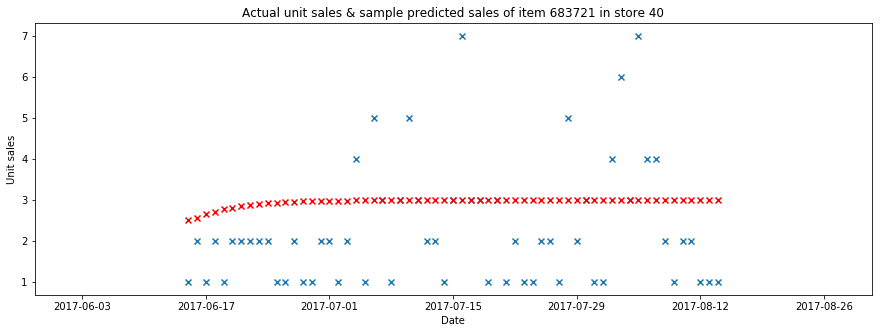


-------------------------------------------------------------

Item ID:  1464092


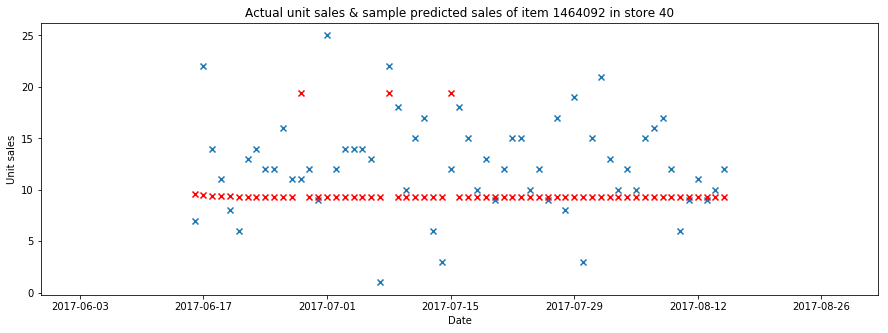


-------------------------------------------------------------

Item ID:  418024


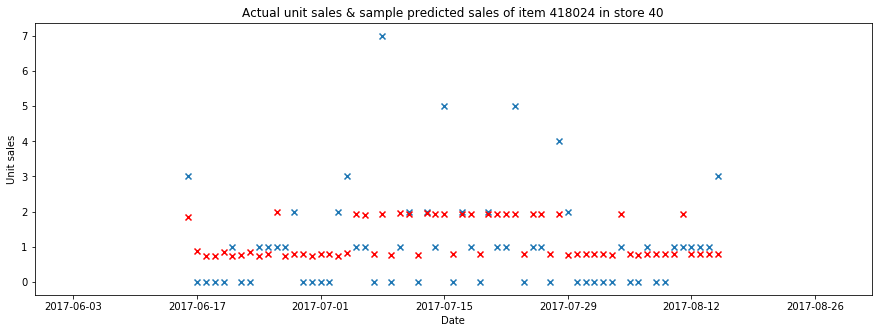


-------------------------------------------------------------

Item ID:  587156

-------------------------------------------------------------

Item ID:  671062


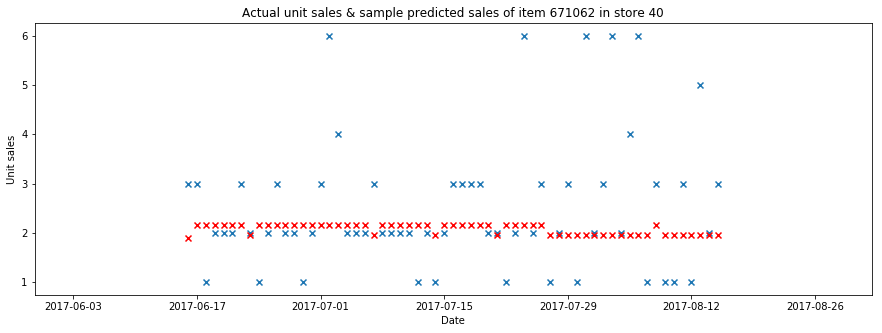


-------------------------------------------------------------

Item ID:  770511


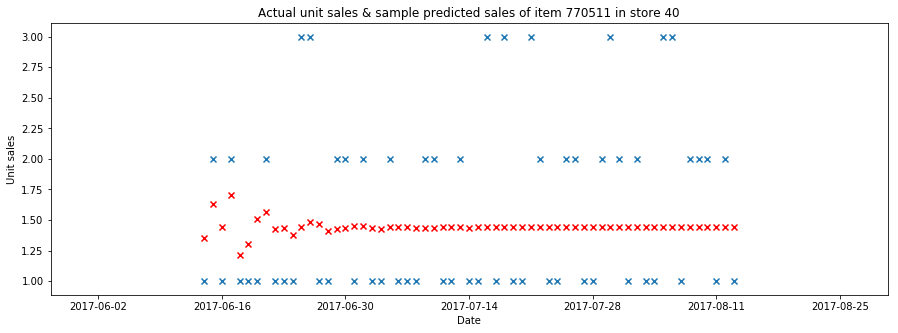


-------------------------------------------------------------

Item ID:  876663


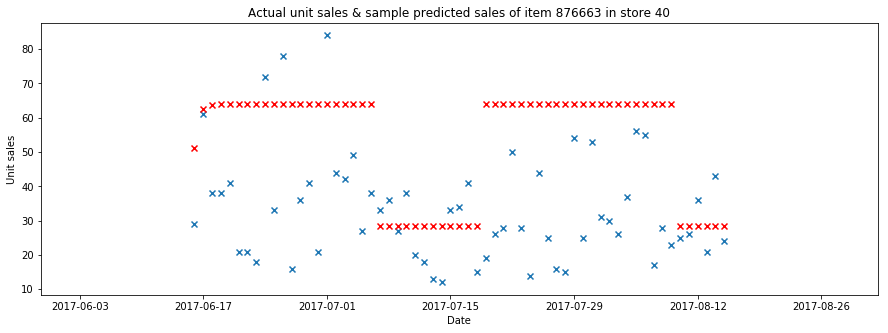


-------------------------------------------------------------

Item ID:  1463510


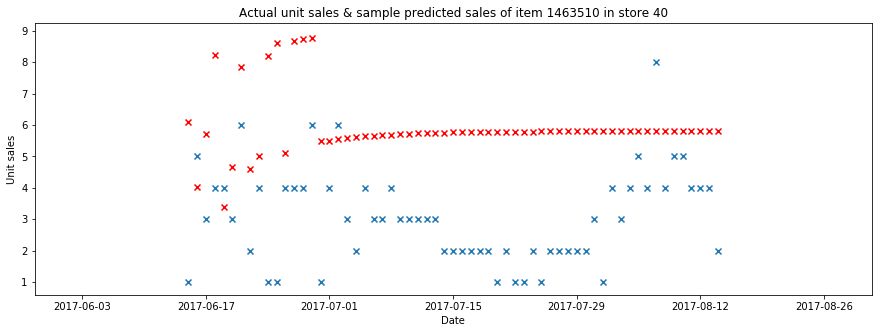


-------------------------------------------------------------

Item ID:  849136

-------------------------------------------------------------



In [104]:
train_rmses = [None]*20
cval_rmses = [None]*20

print("Single regressor dynamic regression model using R's auto arima")
print("-------------------------------------------------------------")

def dynamic_reg_onpromotion_R(dates_cval, item_store_train, item_store_cval):
    item_store_train['onpromotion'] = item_store_train.onpromotion.fillna(False)
    item_store_train['onpromotion'] = item_store_train.onpromotion.map(lambda x: 1 if x == True else 0)
    
    item_store_cval['onpromotion'] = item_store_cval.onpromotion.fillna(False)
    item_store_cval['onpromotion'] = item_store_cval.onpromotion.map(lambda x: 1 if x == True else 0)
    
    item_store_train_R = pandas2ri.py2ri(item_store_train)
    item_store_cval_R = pandas2ri.py2ri(item_store_cval)
    ro.globalenv["item_store_train_R"] = item_store_train_R
    ro.globalenv["item_store_cval_R"] = item_store_cval_R

    xreg_train = ro.r('item_store_train_R[,"onpromotion"]')
    xreg_cval = ro.r('item_store_cval_R[,"onpromotion"]')
    ro.globalenv["xreg_train"] = xreg_train
    ro.globalenv["xreg_cval"] = xreg_cval
    
    if(len(item_store_train[item_store_train['onpromotion'] == 1]) > 0):
        fit = ro.r('auto.arima(item_store_train_R$unit_sales, xreg=xreg_train)')
        ro.globalenv["fit"] = fit
        in_sample_preds = ro.r('item_store_train_R$unit_sales - residuals(fit)')
        preds = ro.r('as.data.frame(forecast(fit, xreg=xreg_cval, h=61))')
        
    else:
        fit = ro.r('auto.arima(item_store_train_R$unit_sales)')
        ro.globalenv["fit"] = fit
        in_sample_preds = ro.r('item_store_train_R$unit_sales - residuals(fit)')
        preds = ro.r('as.data.frame(forecast(fit, h=61))')
        
    return in_sample_preds, preds['Point Forecast']


    
for i in range(len(random_items)):
    print("Item ID: ", random_items[i])
    dates_train, dates_cval, item_store_train, item_store_cval = item_store_dates_train_cval(random_items[i], 40)
    if(len(item_store_train) > 0):
   
        item_store_in_sample_preds, next_61 = dynamic_reg_onpromotion_R(dates_cval, item_store_train, item_store_cval)
    
        plot_actual_preds_together(random_items[i], dates_cval, item_store_cval.unit_sales, next_61)
        train_rmses[i] = rmse(item_store_train.unit_sales, item_store_in_sample_preds)
        cval_rmses[i] = rmse(item_store_cval.unit_sales, np.array(next_61))
        
    print("")
    print("-------------------------------------------------------------")
    print("")

In [106]:
train_rmses = [x for x in train_rmses if x is not None]
cval_rmses = [x for x in cval_rmses if x is not None]

print("Median Training RMSE: ", np.median(train_rmses))
print("Median Cross Validation RMSE: ", np.median(cval_rmses))
print()
print("Mean Training RMSE: ", np.mean(train_rmses))
print("Mean Cross Validation RMSE: ", np.mean(cval_rmses))


Median Training RMSE:  2.25911737012
Median Cross Validation RMSE:  2.84523139679

Mean Training RMSE:  6.30761577632
Mean Cross Validation RMSE:  12.3065132497


Unfortunately, R's auto arima function produces different models from python's auto arima. The results are not better than the baseline. However, this runs much faster.

Anyway, the point of the above was to test dynamic regression with the onpromotion feature. Now I will try Facebook's Prophet library to see oif that performs any better. Perhaps I will then proceed to do some more serious feature engineering so I can produce much more complex dynamic regression models. Hopefully, I will be able to push the error rate down more significantly.

## Forecasting using Facebook's Prophet

In [138]:
# Test for one item in one store

dates_train, dates_cval, item0_store40_train, item0_store40_cval = item_store_dates_train_cval(random_items[0], 40)

item0_store40_train['ds'] = item0_store40_train.date
item0_store40_cval['ds'] = item0_store40_cval.date

item0_store40_train['y'] = item0_store40_train.unit_sales
item0_store40_cval['y'] = item0_store40_cval.unit_sales

prophet_model = Prophet()
prophet_model.fit(item0_store40_train)

future = prophet_model.make_future_dataframe(periods=61)

forecast_df = prophet_model.predict(future)
forecast_df['unit_sales'] = pd.Series.round(forecast_df.yhat)

forecast_df.tail()


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds     trend  trend_lower  trend_upper  yhat_lower  yhat_upper  \
1682 2017-08-11  7.340667     7.330628     7.351923    0.541928   11.600931   
1683 2017-08-12  7.339391     7.329015     7.351020    2.344355   13.551993   
1684 2017-08-13  7.338115     7.327398     7.350137    1.143964   12.300216   
1685 2017-08-14  7.336839     7.325604     7.349246    1.551897   12.779612   
1686 2017-08-15  7.335563     7.323941     7.348256    0.454954   11.899581   

      seasonal  seasonal_lower  seasonal_upper  seasonalities  \
1682 -1.101806       -1.101806       -1.101806      -1.101806   
1683  0.706421        0.706421        0.706421       0.706421   
1684 -0.525535       -0.525535       -0.525535      -0.525535   
1685 -0.169726       -0.169726       -0.169726      -0.169726   
1686 -0.848639       -0.848639       -0.848639      -0.848639   

      seasonalities_lower  seasonalities_upper    weekly  weekly_lower  \
1682            -1.101806            -1.101806 -0.339704     -0.339704   
1683             0.706421             0.706421  1.452668      1.452668   
1684            -0.525535            -0.525535  0.189058      0.189058   
1685            -0.169726            -0.169726  0.498797      0.498797   
1686            -0.848639            -0.848639 -0.238814     -0.238814   

      weekly_upper    yearly  yearly_lower  yearly_upper      yhat  unit_sales  
1682     -0.339704 -0.762102     -0.762102     -0.762102  6.238862         6.0  
1683      1.452668 -0.746247     -0.746247     -0.746247  8.045812         8.0  
1684      0.189058 -0.714593     -0.714593     -0.714593  6.812580         7.0  
1685      0.498797 -0.668523     -0.668523     -0.668523  7.167113         7.0  
1686     -0.238814 -0.609824     -0.609824     -0.609824  6.486925         6.0

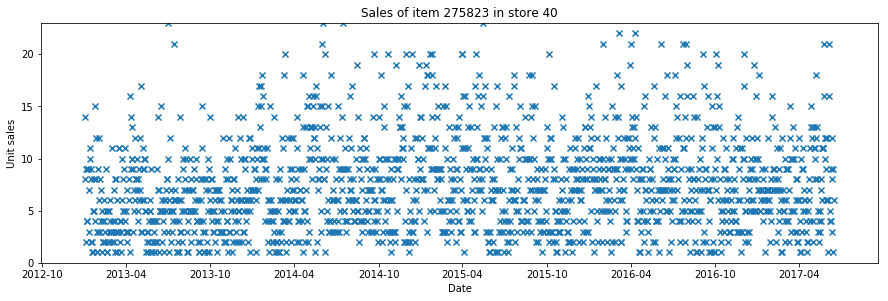

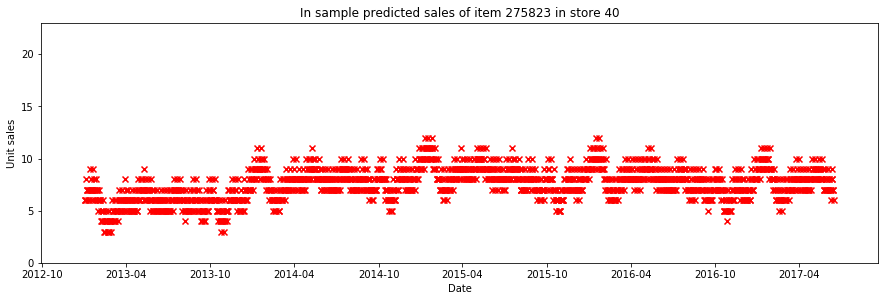

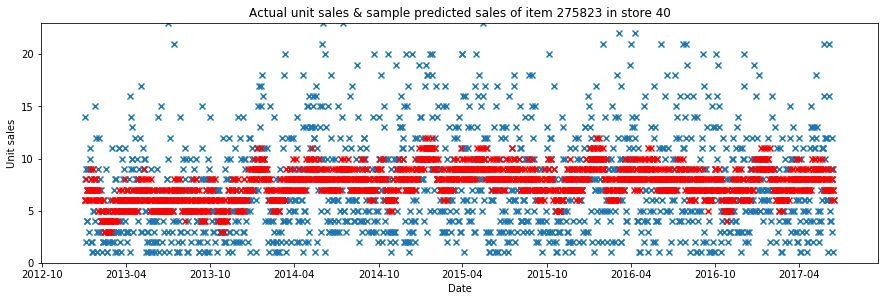

In [140]:
item0_store40_in_sample_preds = forecast_df.unit_sales[:-61]
plot_actual_and_pred_sales(random_items[0], dates_train, item0_store40_train['unit_sales'], item0_store40_in_sample_preds)

And now the next 61 values:

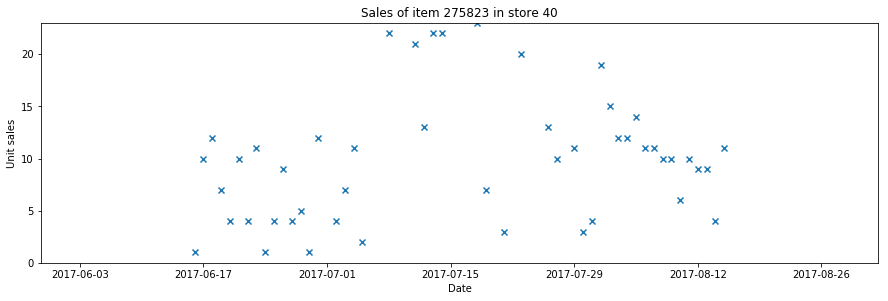

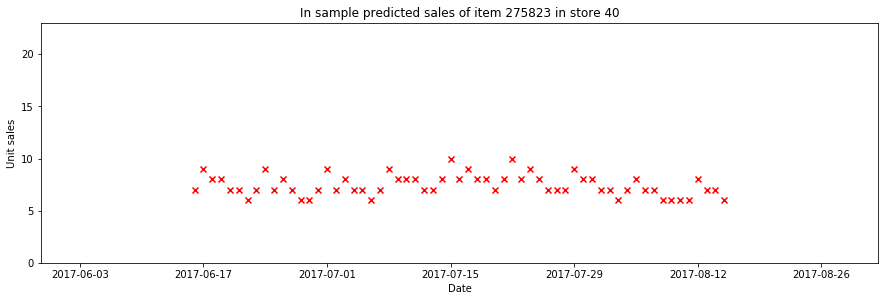

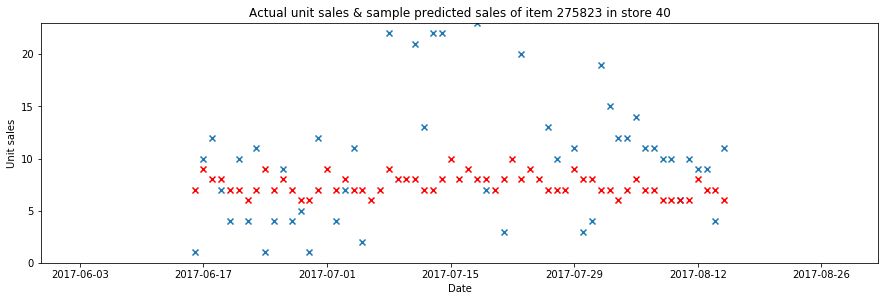

In [141]:
next_61 = forecast_df.unit_sales.tail(61)
plot_actual_and_pred_sales(random_items[0], dates_cval, item0_store40_cval.unit_sales, next_61)

Item ID:  275823


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


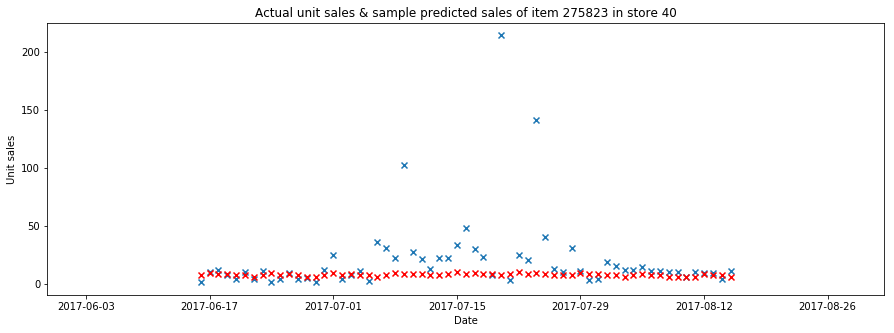


-------------------------------------------------------------

Item ID:  980041

-------------------------------------------------------------

Item ID:  1400331


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


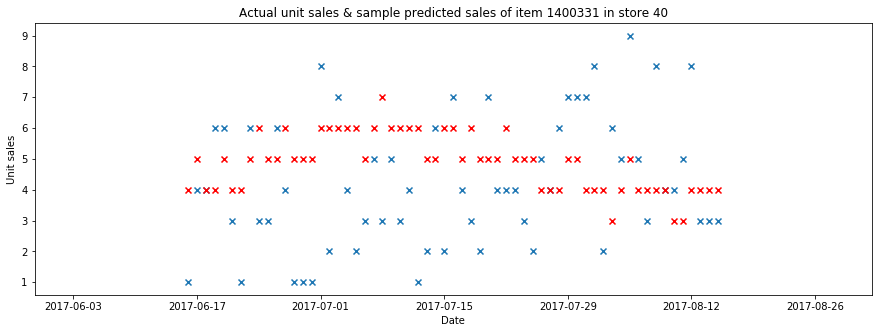


-------------------------------------------------------------

Item ID:  551893


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


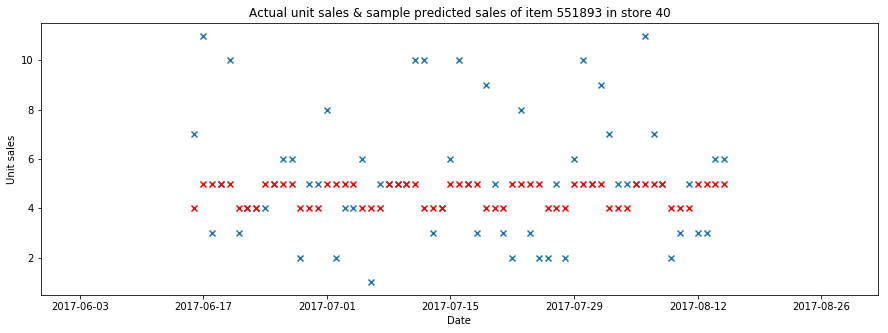


-------------------------------------------------------------

Item ID:  1230418


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


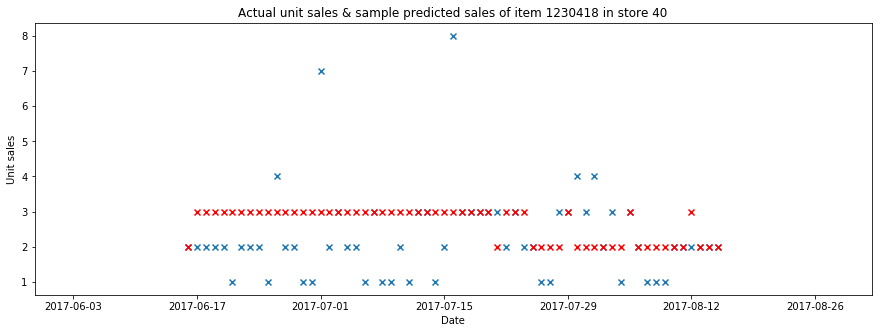


-------------------------------------------------------------

Item ID:  1354719

-------------------------------------------------------------

Item ID:  1165989


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


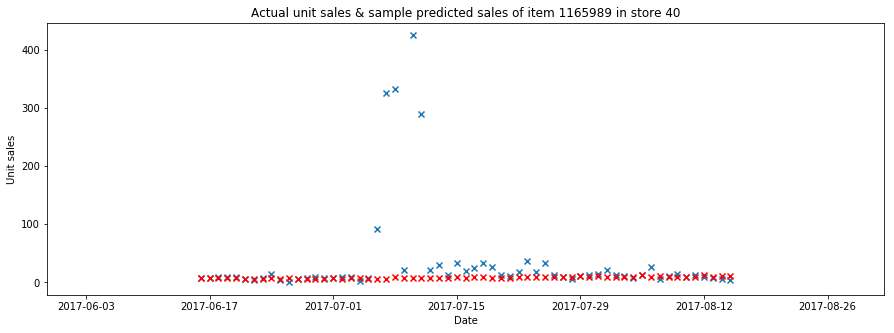


-------------------------------------------------------------

Item ID:  872310


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


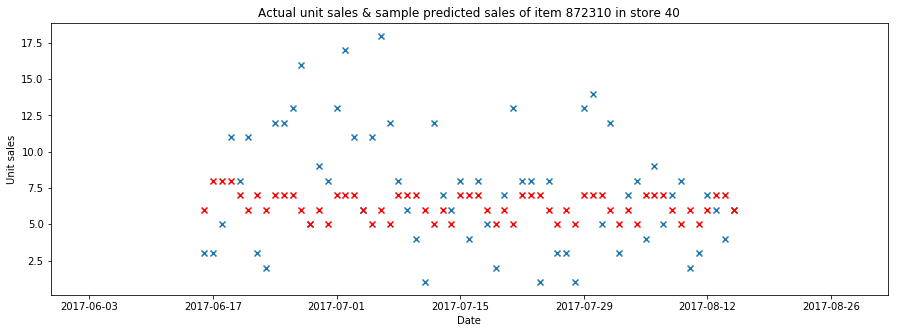


-------------------------------------------------------------

Item ID:  1324670


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


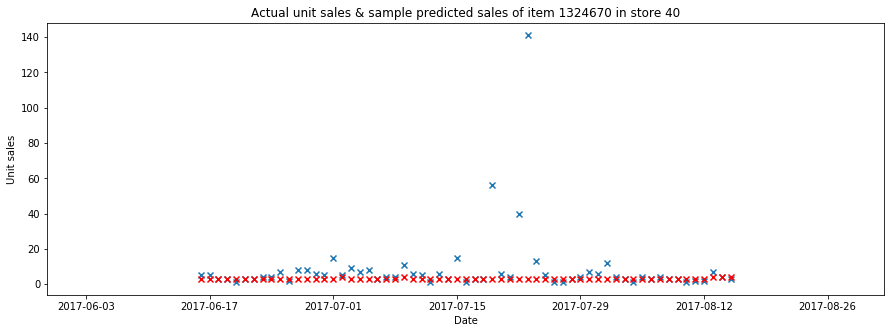


-------------------------------------------------------------

Item ID:  1091370


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


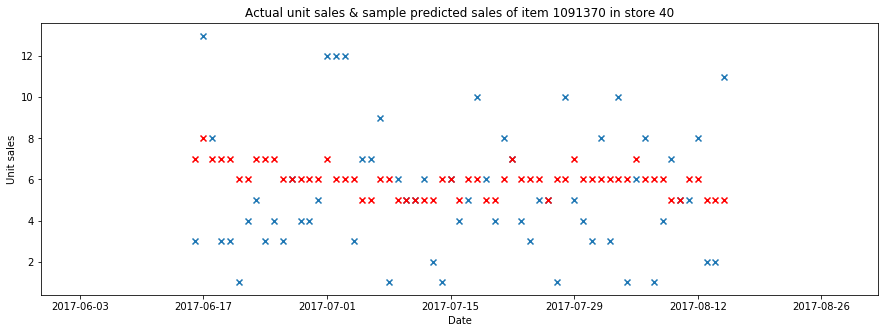


-------------------------------------------------------------

Item ID:  1119216


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


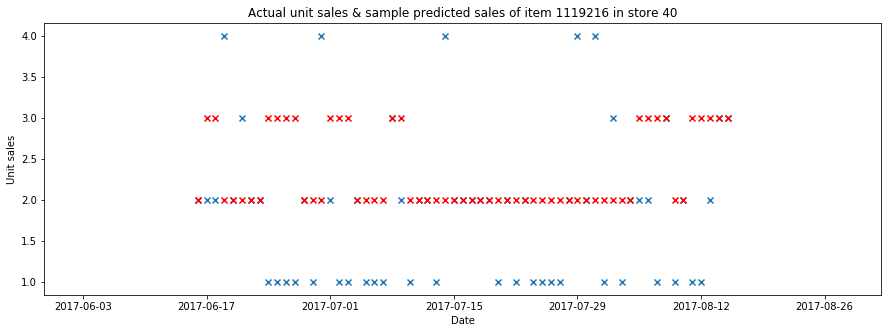


-------------------------------------------------------------

Item ID:  683721


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


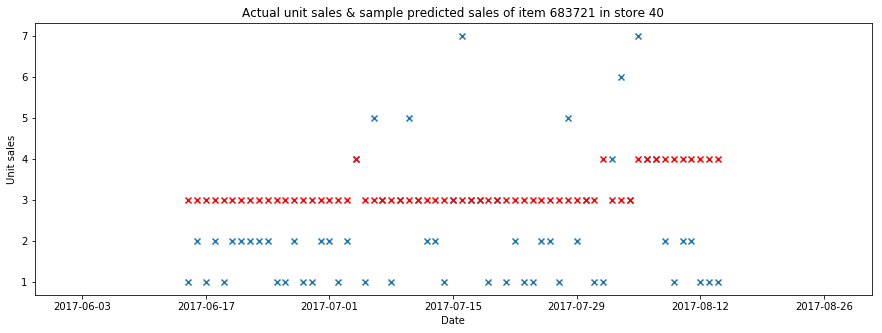


-------------------------------------------------------------

Item ID:  1464092


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


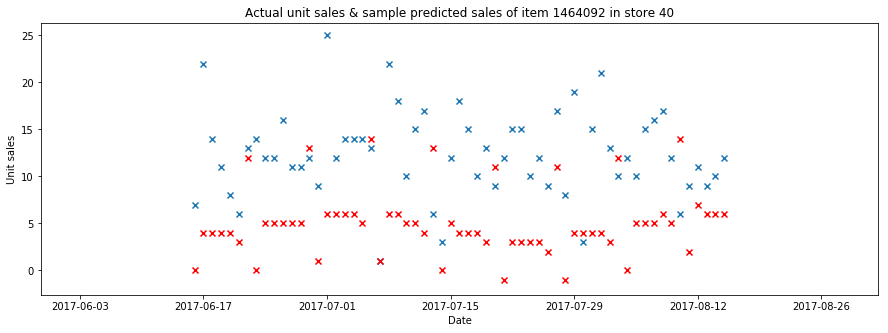


-------------------------------------------------------------

Item ID:  418024


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


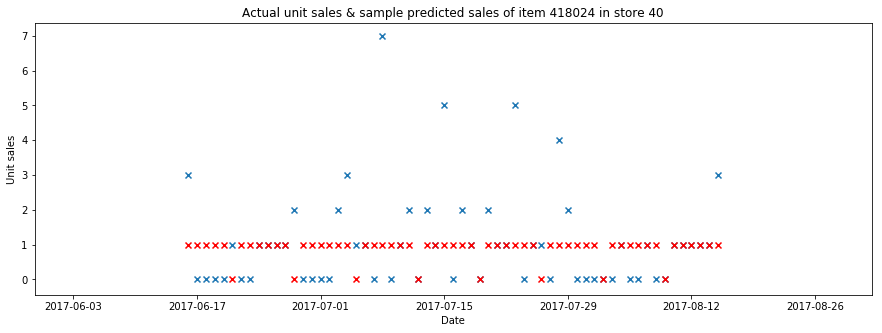


-------------------------------------------------------------

Item ID:  587156

-------------------------------------------------------------

Item ID:  671062


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


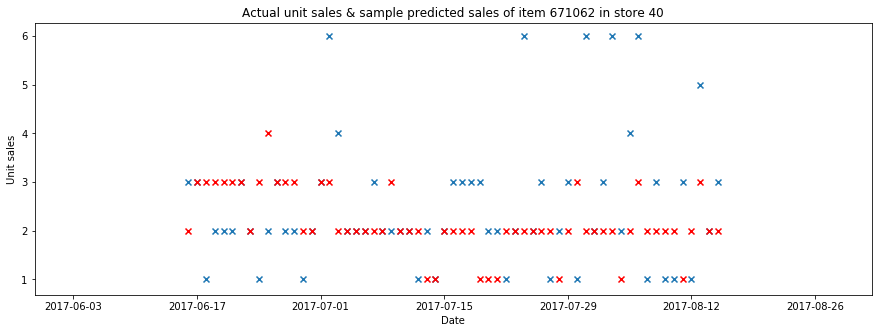


-------------------------------------------------------------

Item ID:  770511


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


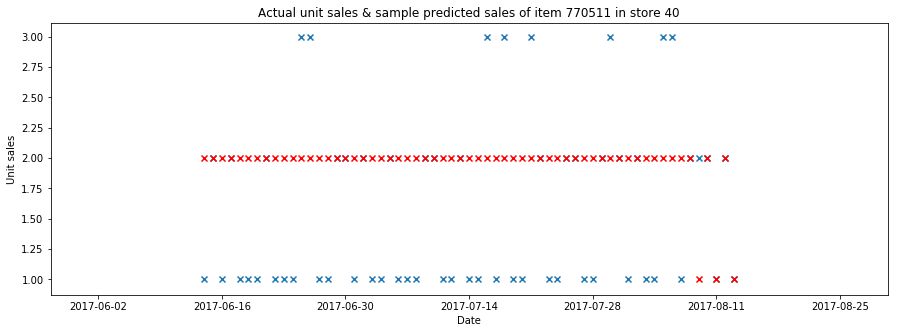


-------------------------------------------------------------

Item ID:  876663


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


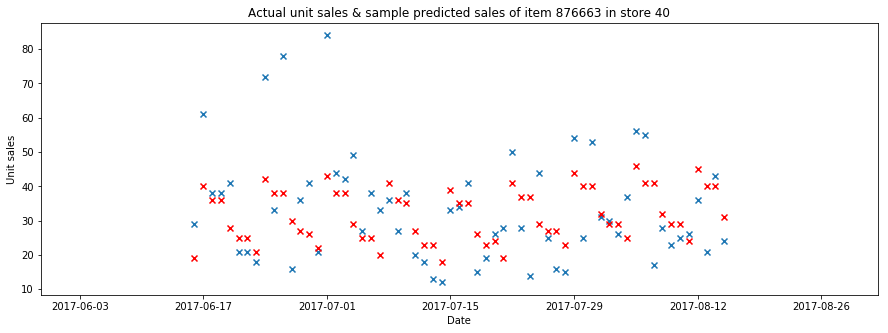


-------------------------------------------------------------

Item ID:  1463510


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


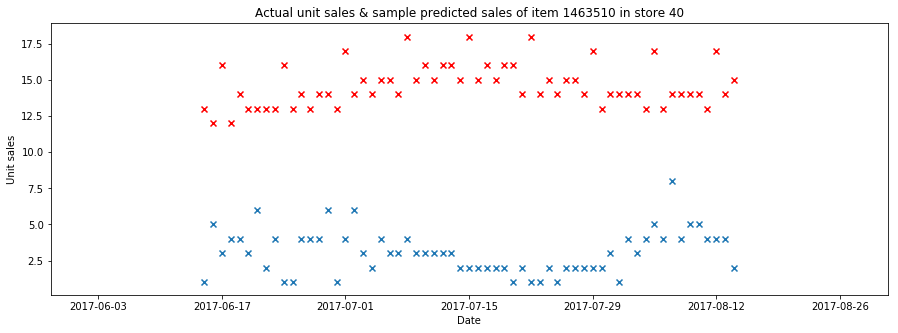


-------------------------------------------------------------

Item ID:  849136

-------------------------------------------------------------



In [131]:
train_rmses = [None]*20
cval_rmses = [None]*20


for i in range(len(random_items)):
    print("Item ID: ", random_items[i])
    dates_train, dates_cval, item_store_train, item_store_cval = item_store_dates_train_cval(random_items[i], 40)
    if(len(item_store_train) > 0):
   
        item_store_train['ds'] = item_store_train.date
        item_store_cval['ds'] = item_store_cval.date
        item_store_train['y'] = item_store_train.unit_sales
        item_store_cval['y'] = item_store_cval.unit_sales

        prophet_model = Prophet()
        prophet_model.fit(item_store_train)
        future = prophet_model.make_future_dataframe(periods=61)
        forecast_df = prophet_model.predict(future)
        forecast_df['unit_sales'] = pd.Series.round(forecast_df.yhat)
        
        item_store_in_sample_preds = forecast_df.unit_sales[:-61]
        
        next_61 = forecast_df.unit_sales.tail(61)
        plot_actual_preds_together(random_items[i], dates_cval, item_store_cval.unit_sales, next_61)
        train_rmses[i] = rmse(item_store_train.unit_sales, item_store_in_sample_preds)
        cval_rmses[i] = rmse(item_store_cval.unit_sales, next_61)
        
    print("")
    print("-------------------------------------------------------------")
    print("")

In [132]:
train_rmses = [x for x in train_rmses if x is not None]
cval_rmses = [x for x in cval_rmses if x is not None]

print("Median Training RMSE: ", np.median(train_rmses))
print("Median Cross Validation RMSE: ", np.median(cval_rmses))
print()
print("Mean Training RMSE: ", np.mean(train_rmses))
print("Mean Cross Validation RMSE: ", np.mean(cval_rmses))


Median Training RMSE:  2.2547501936
Median Cross Validation RMSE:  2.80085951834

Mean Training RMSE:  6.70836264007
Mean Cross Validation RMSE:  12.3516142469


So it looks like facebook's prophet is really just running a faster ARIMA implementation under the hood because the results are very similar to those of the original baseline.

However, prophet does make it easier to add holidays and other regressors and this is the next thing to do.

## Adding the holidays and onpromotion effects to the prophecies

First I need to modify the function that creates the training and cross validation datasets to include the additional regressors. I've also included the code that adds the columns that Prophet needs.

I've also incorporated the forecasting code into its own function. 

All this is just to make my life easier from now onwards when I need to make small changes and test the code. I am going to run these models a number of times and use the RMSE values of the train and cval to adjust for bias and variance.

In [181]:
def datasets_gen_cval(item_nbr, store_nbr):
    item_df = train_df[train_df.item_nbr == item_nbr]
    item_store_df = item_df[item_df.store_nbr == store_nbr]
    
    item_store_df = sales_filler(item_store_df, item_nbr, store_nbr)
    item_store_df['onpromotion'] = item_store_df.onpromotion.fillna(False)
    item_store_df['onpromotion'] = item_store_df.onpromotion.map(lambda x: 1 if x == True else 0)
    
    item_store_train = item_store_df.iloc[:-61,:]
    item_store_cval = item_store_df.iloc[-61:,:]
    
    item_store_train['ds'] = item_store_train.date
    item_store_cval['ds'] = item_store_cval.date
    item_store_train['y'] = item_store_train.unit_sales
    item_store_cval['y'] = item_store_cval.unit_sales
    
    dates_train = [d.to_pydatetime() for d in item_store_train.date]
    dates_cval = [d.to_pydatetime() for d in item_store_cval.date]
    
    return dates_train, dates_cval, item_store_train, item_store_cval

def gen_forecasts_for_cval(train_df, cval_df):
    prophet_model = Prophet()
    
    if train_df.onpromotion.any():
        prophet_model.add_regressor('onpromotion')
        prophet_model.fit(train_df)
        
        future = prophet_model.make_future_dataframe(periods=61)
        onpromotion = train_df.onpromotion.append(cval_df.onpromotion)
    
        future['onpromotion'] = onpromotion
    else:
        prophet_model.fit(train_df)
        future = prophet_model.make_future_dataframe(periods=61)
    
    forecast_df = prophet_model.predict(future)
    #forecast_df['unit_sales'] = pd.Series.round(forecast_df.yhat)
    forecast_df['unit_sales'] = forecast_df.yhat
    
    in_sample_preds = forecast_df.unit_sales[:-61]
    next_61 = forecast_df.unit_sales.tail(61)
    
    return in_sample_preds, next_61

Now for the forecast plots and RMSE evaluations ...

Item ID:  275823


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

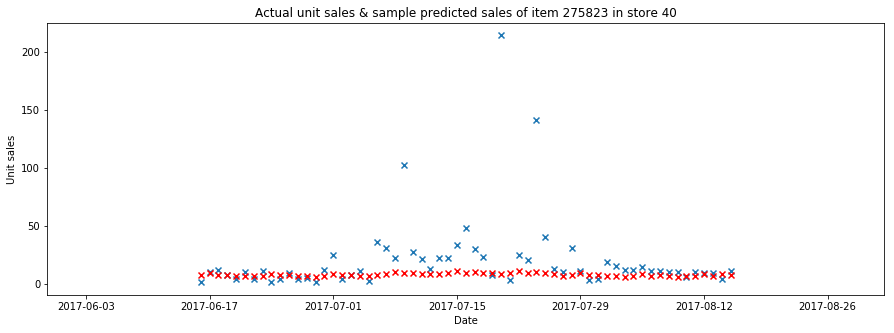


-------------------------------------------------------------

Item ID:  980041

-------------------------------------------------------------

Item ID:  1400331


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


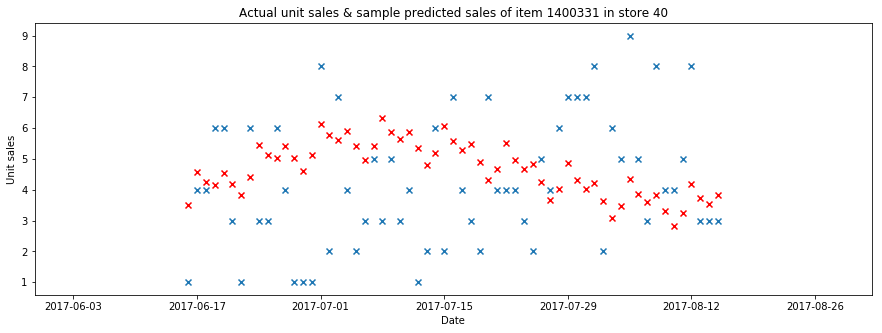


-------------------------------------------------------------

Item ID:  551893


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


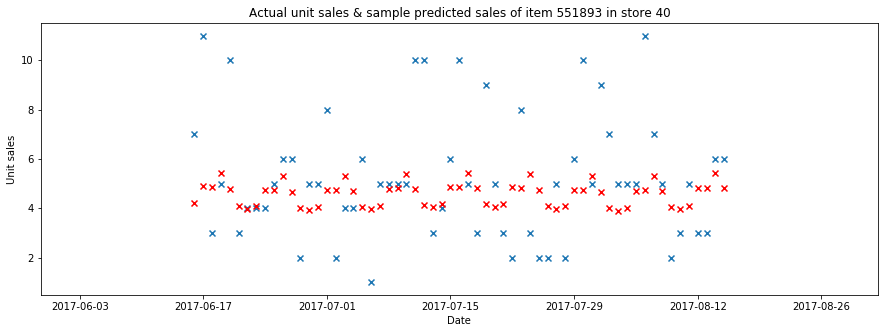


-------------------------------------------------------------

Item ID:  1230418


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


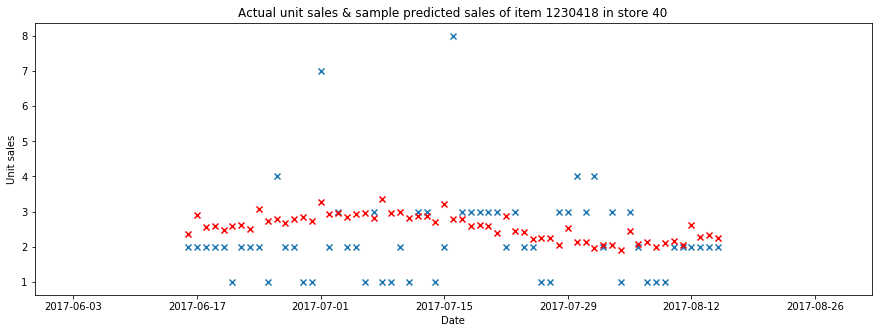


-------------------------------------------------------------

Item ID:  1354719

-------------------------------------------------------------

Item ID:  1165989


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


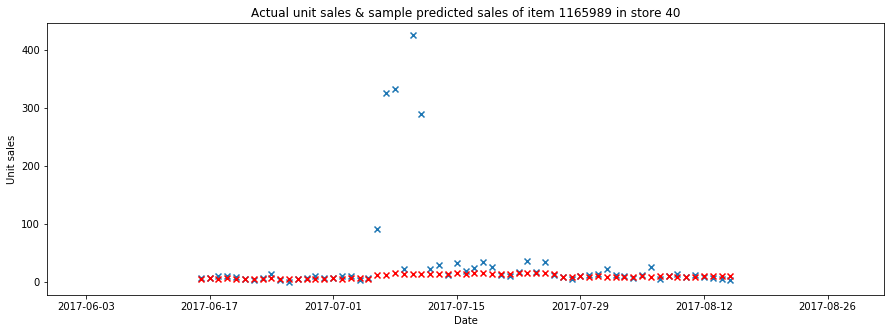


-------------------------------------------------------------

Item ID:  872310


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


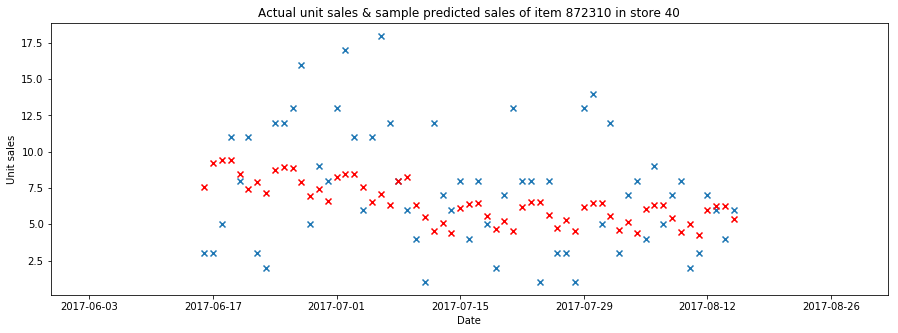


-------------------------------------------------------------

Item ID:  1324670


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


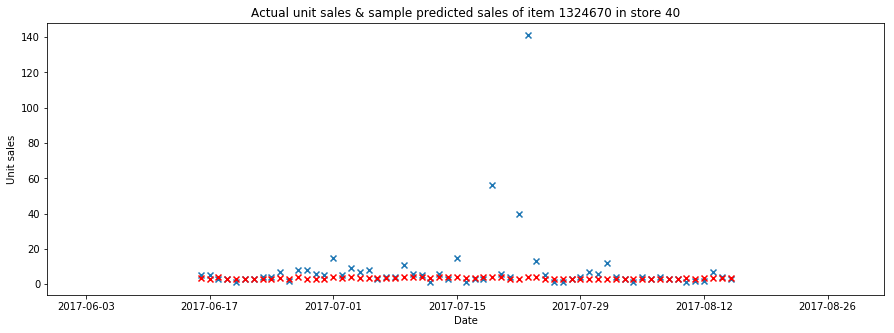


-------------------------------------------------------------

Item ID:  1091370


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


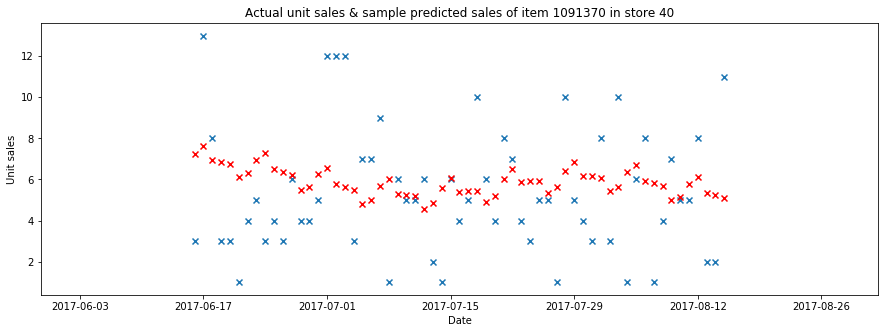


-------------------------------------------------------------

Item ID:  1119216


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


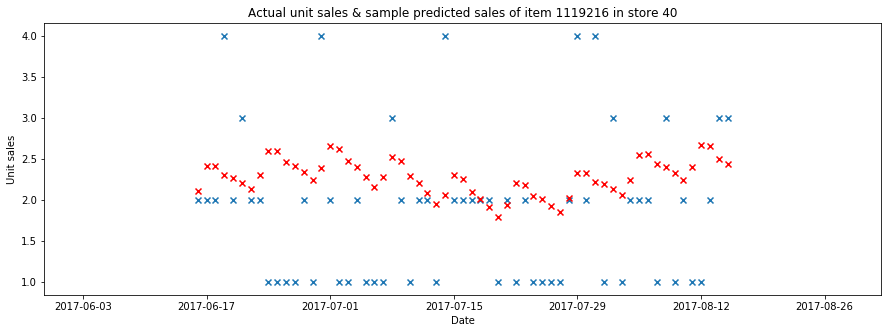


-------------------------------------------------------------

Item ID:  683721


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


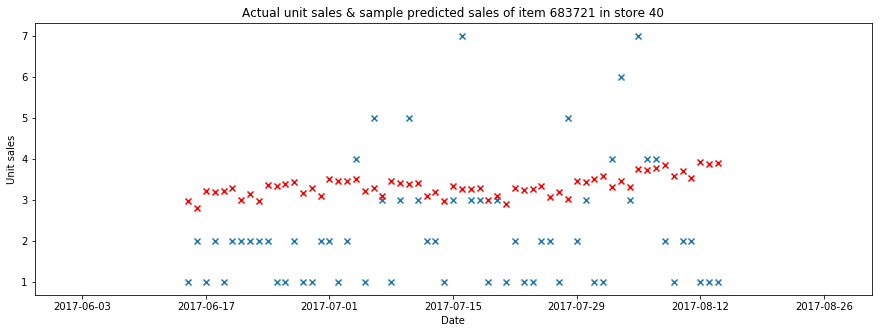


-------------------------------------------------------------

Item ID:  1464092


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


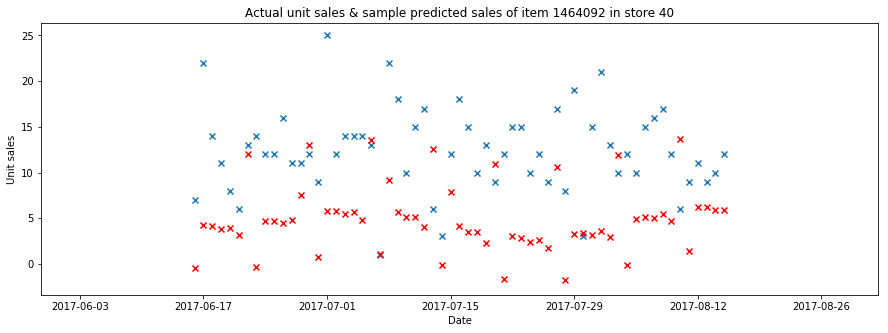


-------------------------------------------------------------

Item ID:  418024


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


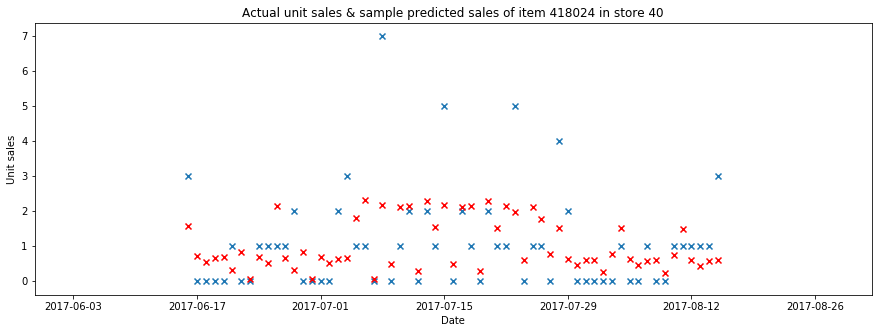


-------------------------------------------------------------

Item ID:  587156

-------------------------------------------------------------

Item ID:  671062


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


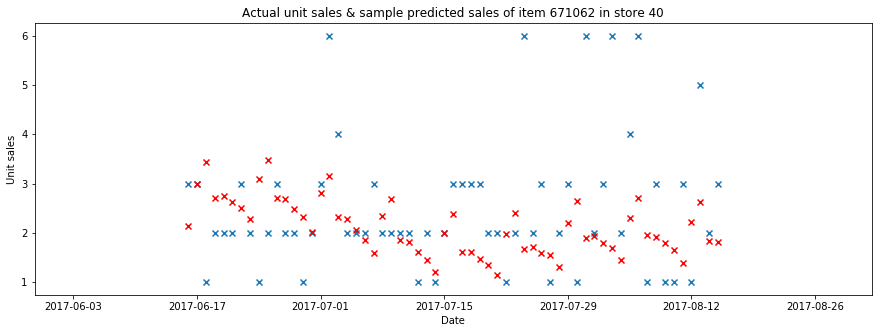


-------------------------------------------------------------

Item ID:  770511


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


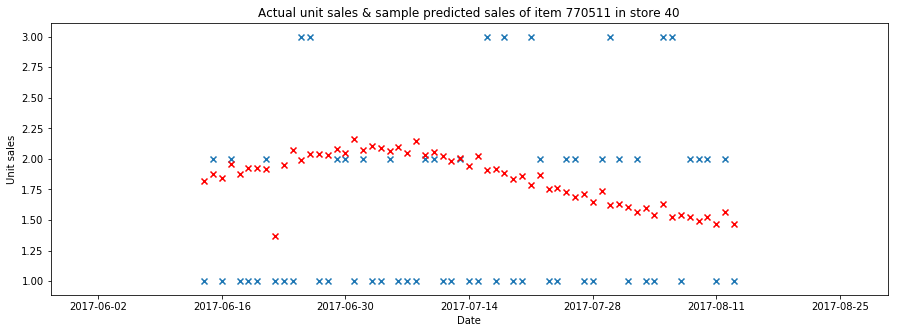


-------------------------------------------------------------

Item ID:  876663


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


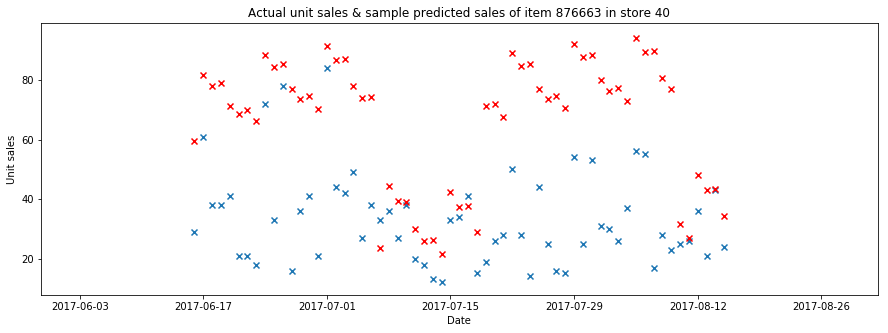


-------------------------------------------------------------

Item ID:  1463510


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


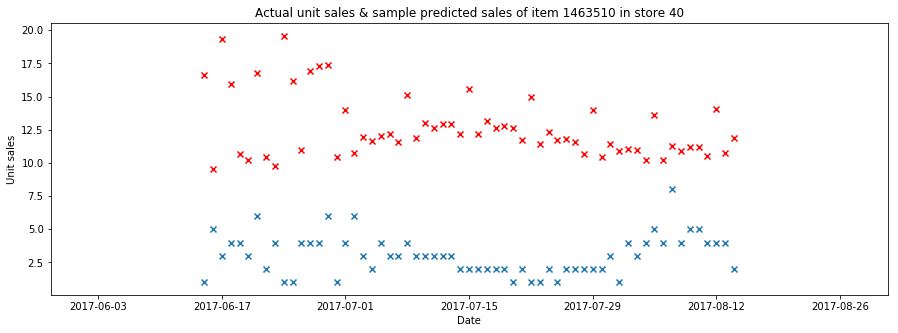


-------------------------------------------------------------

Item ID:  849136

-------------------------------------------------------------



In [182]:
train_rmses = [None]*20
cval_rmses = [None]*20

for i in range(len(random_items)):
    print("Item ID: ", random_items[i])
    dates_train, dates_cval, item_store_train, item_store_cval = datasets_gen_cval(random_items[i], 40)
    if(len(item_store_train) > 0):
   
        item_store_in_sample_preds, next_61 = gen_forecasts_for_cval(item_store_train, item_store_cval)
        
        plot_actual_preds_together(random_items[i], dates_cval, item_store_cval.unit_sales, next_61)
        train_rmses[i] = rmse(item_store_train.unit_sales, item_store_in_sample_preds)
        cval_rmses[i] = rmse(item_store_cval.unit_sales, next_61)
        
    print("")
    print("-------------------------------------------------------------")
    print("")
    

In [180]:
train_rmses = [x for x in train_rmses if x is not None]
cval_rmses = [x for x in cval_rmses if x is not None]

print("Median Training RMSE: ", np.median(train_rmses))
print("Median Cross Validation RMSE: ", np.median(cval_rmses))
print()
print("Mean Training RMSE: ", np.mean(train_rmses))
print("Mean Cross Validation RMSE: ", np.mean(cval_rmses))

Median Training RMSE:  2.23472661625
Median Cross Validation RMSE:  2.83922453577

Mean Training RMSE:  6.68543093335
Mean Cross Validation RMSE:  12.3386937463


I'm running into the problem of training time once again. The Prophet framework is simply too slow to keep using for this problem.
I will now try a completely different approach

## Dataset creation for use in XGBoost

Before I can apply XGBoost I will need to prepare a new dataset. I will reduce the size of the training data because 4 years worth of data seems excessive for what I want to now try. I will then fill in missing sales values as I did before, before moving onto the creation of new features. 

I will also apply XGBoost in a recursive manner - forecasting one day ahead each time and then using the newly forecasted value as part of the input into the next day's forecast - tricky !

In [2]:
train_df = pd.read_csv('datasets/train.csv',
    converters={'unit_sales': lambda u: float(u) },
    parse_dates=["date"],
    skiprows=range(1, 66458909))  # 2016-01-01

test_df = pd.read_csv('datasets/test.csv', parse_dates=["date"])  

Now to fill in the missing sales - initally with zeros

In [3]:
u_dates = train_df.date.unique()
u_stores = train_df.store_nbr.unique()
u_items = train_df.item_nbr.unique()

train_df.set_index(['date', 'store_nbr', 'item_nbr'], inplace=True)
train_df = train_df.reindex(
    pd.MultiIndex.from_product(
        (u_dates, u_stores, u_items),
        names=['date','store_nbr','item_nbr']
    )
).reset_index()

del u_dates, u_stores, u_items

train_df.loc[:, 'unit_sales'].fillna(0, inplace=True)


I need to now merge the train and test datasets

In [4]:
merged_df = pd.concat([train_df, test_df], axis=0)
merged_df.tail()

date           id  item_nbr onpromotion  store_nbr  unit_sales
3370459 2017-08-31  128867499.0   2132163       False         54         NaN
3370460 2017-08-31  128867500.0   2132318       False         54         NaN
3370461 2017-08-31  128867501.0   2132945       False         54         NaN
3370462 2017-08-31  128867502.0   2132957       False         54         NaN
3370463 2017-08-31  128867503.0   2134244       False         54         NaN

Now to add items data and make the onpromotion a binary varaible

In [5]:
items_df = pd.read_csv('datasets/items.csv')
merged_df = merged_df.merge(items_df, on='item_nbr', how='left')

merged_df['onpromotion'] = merged_df.onpromotion.fillna(False)
merged_df['onpromotion'] = merged_df.onpromotion.map(lambda x: 1 if x == True else 0)

Now I'm going to build a dataset containing just the last 60 days worth of data leading up to the first date in the test set. 
However, this dataset will contain new features corresponding to historical mean sales values 

In [6]:
def calc_historical_sales_avg(todays_date, days_before):
    tmp = merged_df[merged_df.date < todays_date]
    tmp = tmp[tmp.date >= todays_date - timedelta(int(days_before))]

    tmpg = tmp.groupby(['item_nbr','store_nbr'])['unit_sales'].mean()
    avg_sales_series = tmpg.rename(str(days_before) + "days_avg_sales")
    
    return avg_sales_series

def prev_days_sales(todays_date, days_before):
    tmp = merged_df[merged_df.date == todays_date - timedelta(int(days_before))]
    tmpg = tmp.set_index(['item_nbr','store_nbr'])['unit_sales']
    prev_days_sales = tmpg.rename(str(days_before) + "days_prev_sales")
    
    return prev_days_sales

def prepare_xgb_training_data(todays_date):
    merged_df_copy = merged_df.copy()

    for days_before in [56,28,14,7,3]:
        avg_sales_series = calc_historical_sales_avg(todays_date, days_before)
        todays_date_reindexed_df = merged_df_copy[merged_df_copy.date == todays_date].set_index(['item_nbr','store_nbr'], inplace=False)
        todays_date_df = pd.concat([todays_date_reindexed_df, avg_sales_series], axis=1)
        merged_df_copy = todays_date_df.reset_index().copy()
    
    prev_sales_series = prev_days_sales(todays_date, 1)
    todays_date_reindexed_df = merged_df_copy[merged_df_copy.date == todays_date].set_index(['item_nbr','store_nbr'], inplace=False)
    todays_date_df = pd.concat([todays_date_reindexed_df, prev_sales_series], axis=1)
    merged_df_copy = todays_date_df.reset_index().copy()
    
    training_X = merged_df_copy.drop(['item_nbr', 'store_nbr', 'date', 'id', 'unit_sales', 'family', 'class'], axis=1)
    training_Y = merged_df_copy.unit_sales
    index_cols = merged_df_copy[['date', 'item_nbr', 'store_nbr']]
    
    return index_cols, training_X, training_Y

def prepare_xgb_pred_data(todays_date):
    merged_df_copy = merged_df.copy()

    for days_before in [56,28,14,7,3]:
        avg_sales_series = calc_historical_sales_avg(todays_date, days_before)
        todays_date_reindexed_df = merged_df_copy[merged_df_copy.date == todays_date].set_index(['item_nbr','store_nbr'], inplace=False)
        todays_date_df = pd.concat([todays_date_reindexed_df, avg_sales_series], axis=1)
        merged_df_copy = todays_date_df.reset_index().copy()
    
    prev_sales_series = prev_days_sales(todays_date, 1)
    todays_date_reindexed_df = merged_df_copy[merged_df_copy.date == todays_date].set_index(['item_nbr','store_nbr'], inplace=False)
    todays_date_df = pd.concat([todays_date_reindexed_df, prev_sales_series], axis=1)
    merged_df_copy = todays_date_df.reset_index().copy()
    
    training_X = merged_df_copy.drop(['item_nbr', 'store_nbr', 'date', 'id', 'unit_sales', 'family', 'class'], axis=1)
    training_Y = merged_df_copy.unit_sales
    index_cols = merged_df_copy[['date', 'item_nbr', 'store_nbr']]
    
    return index_cols, training_X, training_Y

In [7]:
date_for_training = train_df.iloc[train_df.shape[0]-1].date # 2017-08-15
train_index, new_train_X, new_train_Y = prepare_xgb_training_data(date_for_training)

new_train_X.head()

onpromotion  perishable  56days_avg_sales  28days_avg_sales  \
0            0           0          0.303571          0.535714   
1            0           0          0.178571          0.107143   
2            0           0          0.446429          0.500000   
3            0           0          0.232143          0.142857   
4            0           0          0.410714          0.642857   

   14days_avg_sales  7days_avg_sales  3days_avg_sales  1days_prev_sales  
0          0.571429         0.142857         0.000000               0.0  
1          0.000000         0.000000         0.000000               0.0  
2          0.500000         0.714286         0.333333               1.0  
3          0.142857         0.142857         0.333333               0.0  
4          0.142857         0.285714         0.000000               0.0

Now I will examine the sample submission and test sets

## XGBoost for submission

In [8]:
# split data into train and test sets
seed = 7
test_size = 0.2
X_train, X_cval, y_train, y_cval = train_test_split(new_train_X, new_train_Y, test_size=test_size, random_state=seed)

# fit model no training data
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [9]:
# make predictions for test data

test_index, new_test_X, new_test_Y = prepare_xgb_pred_data(date_for_training + timedelta(int(1)) )

y_pred = model.predict(new_test_X)

In [10]:
tmp = test_index.copy()
tmp['unit_sales'] = pd.Series(y_pred, name='unit_sales')

tmp.set_index(['date', 'store_nbr', 'item_nbr'], inplace=True)
merged_df.set_index(['date', 'store_nbr', 'item_nbr'], inplace=True)

merged_df.update(tmp)

merged_df = merged_df.reset_index()

In [9]:
for i in range(1,17):
    pred_date = date_for_training + timedelta(int(i))
    print("Creating predictions for " + str(pred_date))
    
    test_index, new_test_X, new_test_Y = prepare_xgb_pred_data(pred_date)
    y_pred = model.predict(new_test_X)
    
    tmp = test_index.copy()
    tmp['unit_sales'] = pd.Series(y_pred, name='unit_sales')

    tmp.set_index(['date', 'store_nbr', 'item_nbr'], inplace=True)
    merged_df.set_index(['date', 'store_nbr', 'item_nbr'], inplace=True)
    merged_df.update(tmp)
    merged_df = merged_df.reset_index()



Creating predictions for 2017-08-16 00:00:00
Creating predictions for 2017-08-17 00:00:00
Creating predictions for 2017-08-18 00:00:00
Creating predictions for 2017-08-19 00:00:00
Creating predictions for 2017-08-20 00:00:00
Creating predictions for 2017-08-21 00:00:00
Creating predictions for 2017-08-22 00:00:00
Creating predictions for 2017-08-23 00:00:00
Creating predictions for 2017-08-24 00:00:00
Creating predictions for 2017-08-25 00:00:00
Creating predictions for 2017-08-26 00:00:00
Creating predictions for 2017-08-27 00:00:00
Creating predictions for 2017-08-28 00:00:00
Creating predictions for 2017-08-29 00:00:00
Creating predictions for 2017-08-30 00:00:00
Creating predictions for 2017-08-31 00:00:00


In [29]:
submission = merged_df[merged_df.date > date_for_training]
submission.loc[(submission.unit_sales < 0), 'unit_sales'] = 0

submission = submission.drop(['date', 'store_nbr', 'item_nbr', 'onpromotion', 'family', 'class', 'perishable'], axis=1)
submission['id'] = submission.id.astype(int)
submission.to_csv('submission.csv', index=False)

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# Not important beyond this point ...

## Feature engineering on store, item and holiday data

I will now engineer features from other datasets available to me with the eventual aim of building much larger training and test datasets. 

In [3]:
# Now apply the feature engineering I used before for the onpromotion feature to the whole training set

train_df['onpromotion'] = train_df.onpromotion.fillna(False)
train_df['onpromotion'] = train_df.onpromotion.map(lambda x: 1 if x == True else 0)

**Now consider data on stores:**

In [4]:
# Now let us consider the dataset on stores

stores_df = pd.read_csv('datasets/stores.csv')

stores_df.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [5]:
cities_df = pd.get_dummies(stores_df.city, prefix='city')
states_df = pd.get_dummies(stores_df.state, prefix='state')
type_df = pd.get_dummies(stores_df.type, prefix='type')

print("The number of additional columns: ", len(cities_df.columns.values) + len(states_df.columns.values) + len(type_df.columns.values))

The number of additional columns:  43


In [6]:
stores_df = pd.concat([stores_df, cities_df, states_df, type_df], axis=1)
stores_df = stores_df.drop(['city', 'state', 'type'], axis=1)

stores_df.head()

store_nbr  cluster  city_Ambato  city_Babahoyo  city_Cayambe  city_Cuenca  \
0          1       13            0              0             0            0   
1          2       13            0              0             0            0   
2          3        8            0              0             0            0   
3          4        9            0              0             0            0   
4          5        4            0              0             0            0   

   city_Daule  city_El Carmen  city_Esmeraldas  city_Guaranda   ...    \
0           0               0                0              0   ...     
1           0               0                0              0   ...     
2           0               0                0              0   ...     
3           0               0                0              0   ...     
4           0               0                0              0   ...     

   state_Pastaza  state_Pichincha  state_Santa Elena  \
0              0                1                  0   
1              0                1                  0   
2              0                1                  0   
3              0                1                  0   
4              0                0                  0   

   state_Santo Domingo de los Tsachilas  state_Tungurahua  type_A  type_B  \
0                                     0                 0       0       0   
1                                     0                 0       0       0   
2                                     0                 0       0       0   
3                                     0                 0       0       0   
4                                     1                 0       0       0   

   type_C  type_D  type_E  
0       0       1       0  
1       0       1       0  
2       0       1       0  
3       0       1       0  
4       0       1       0  

[5 rows x 45 columns]

**Now consider the data on items:**

In [7]:
items_df = pd.read_csv('datasets/items.csv')

items_df.head()

item_nbr        family  class  perishable
0     96995     GROCERY I   1093           0
1     99197     GROCERY I   1067           0
2    103501      CLEANING   3008           0
3    103520     GROCERY I   1028           0
4    103665  BREAD/BAKERY   2712           1

In [8]:
family_df = pd.get_dummies(items_df.family, prefix='family')
class_df = pd.get_dummies(items_df['class'] , prefix='class')

print("The number of additional columns: ", len(family_df.columns.values) + len(class_df.columns.values))

The number of additional columns:  370


In [9]:
items_df = pd.concat([items_df, family_df, class_df], axis=1)
items_df = items_df.drop(["family", "class"], axis=1)

items_df.head()

item_nbr  perishable  family_AUTOMOTIVE  family_BABY CARE  family_BEAUTY  \
0     96995           0                  0                 0              0   
1     99197           0                  0                 0              0   
2    103501           0                  0                 0              0   
3    103520           0                  0                 0              0   
4    103665           1                  0                 0              0   

   family_BEVERAGES  family_BOOKS  family_BREAD/BAKERY  family_CELEBRATION  \
0                 0             0                    0                   0   
1                 0             0                    0                   0   
2                 0             0                    0                   0   
3                 0             0                    0                   0   
4                 0             0                    1                   0   

   family_CLEANING     ...      class_6920  class_6922  class_6924  \
0                0     ...               0           0           0   
1                0     ...               0           0           0   
2                1     ...               0           0           0   
3                0     ...               0           0           0   
4                0     ...               0           0           0   

   class_6936  class_6954  class_6960  class_7002  class_7016  class_7034  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   class_7780  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 372 columns]

**Now consider the data on holidays:**

In [10]:
holidays_df = pd.read_csv('datasets/holidays_events.csv')

holidays_df.head(25)

date      type    locale                     locale_name  \
0   2012-03-02   Holiday     Local                           Manta   
1   2012-04-01   Holiday  Regional                        Cotopaxi   
2   2012-04-12   Holiday     Local                          Cuenca   
3   2012-04-14   Holiday     Local                        Libertad   
4   2012-04-21   Holiday     Local                        Riobamba   
5   2012-05-12   Holiday     Local                            Puyo   
6   2012-06-23   Holiday     Local                        Guaranda   
7   2012-06-25   Holiday  Regional                        Imbabura   
8   2012-06-25   Holiday     Local                       Latacunga   
9   2012-06-25   Holiday     Local                         Machala   
10  2012-07-03   Holiday     Local                   Santo Domingo   
11  2012-07-03   Holiday     Local                       El Carmen   
12  2012-07-23   Holiday     Local                         Cayambe   
13  2012-08-05   Holiday     Local                      Esmeraldas   
14  2012-08-10   Holiday  National                         Ecuador   
15  2012-08-15   Holiday     Local                        Riobamba   
16  2012-08-24   Holiday     Local                          Ambato   
17  2012-09-28   Holiday     Local                          Ibarra   
18  2012-10-07   Holiday     Local                         Quevedo   
19  2012-10-09   Holiday  National                         Ecuador   
20  2012-10-12  Transfer  National                         Ecuador   
21  2012-11-02   Holiday  National                         Ecuador   
22  2012-11-03   Holiday  National                         Ecuador   
23  2012-11-06   Holiday  Regional  Santo Domingo de los Tsachilas   
24  2012-11-07   Holiday  Regional                     Santa Elena   

                            description  transferred  
0                    Fundacion de Manta        False  
1         Provincializacion de Cotopaxi        False  
2                   Fundacion de Cuenca        False  
3             Cantonizacion de Libertad        False  
4             Cantonizacion de Riobamba        False  
5                Cantonizacion del Puyo        False  
6             Cantonizacion de Guaranda        False  
7         Provincializacion de Imbabura        False  
8            Cantonizacion de Latacunga        False  
9                  Fundacion de Machala        False  
10           Fundacion de Santo Domingo        False  
11           Cantonizacion de El Carmen        False  
12             Cantonizacion de Cayambe        False  
13              Fundacion de Esmeraldas        False  
14        Primer Grito de Independencia        False  
15                Fundacion de Riobamba        False  
16                  Fundacion de Ambato        False  
17                  Fundacion de Ibarra        False  
18             Cantonizacion de Quevedo        False  
19           Independencia de Guayaquil         True  
20  Traslado Independencia de Guayaquil        False  
21                      Dia de Difuntos        False  
22              Independencia de Cuenca        False  
23   Provincializacion de Santo Domingo        False  
24        Provincializacion Santa Elena        False

In [11]:
day_off = holidays_df.apply(lambda r: 1 if r['transferred'] == False else 0, axis=1)
holidays_df['day_off'] = day_off

holidays_df = holidays_df.drop(['type', 'description'], axis=1)
holidays_df.head(25)

date    locale                     locale_name  transferred  day_off
0   2012-03-02     Local                           Manta        False        1
1   2012-04-01  Regional                        Cotopaxi        False        1
2   2012-04-12     Local                          Cuenca        False        1
3   2012-04-14     Local                        Libertad        False        1
4   2012-04-21     Local                        Riobamba        False        1
5   2012-05-12     Local                            Puyo        False        1
6   2012-06-23     Local                        Guaranda        False        1
7   2012-06-25  Regional                        Imbabura        False        1
8   2012-06-25     Local                       Latacunga        False        1
9   2012-06-25     Local                         Machala        False        1
10  2012-07-03     Local                   Santo Domingo        False        1
11  2012-07-03     Local                       El Carmen        False        1
12  2012-07-23     Local                         Cayambe        False        1
13  2012-08-05     Local                      Esmeraldas        False        1
14  2012-08-10  National                         Ecuador        False        1
15  2012-08-15     Local                        Riobamba        False        1
16  2012-08-24     Local                          Ambato        False        1
17  2012-09-28     Local                          Ibarra        False        1
18  2012-10-07     Local                         Quevedo        False        1
19  2012-10-09  National                         Ecuador         True        0
20  2012-10-12  National                         Ecuador        False        1
21  2012-11-02  National                         Ecuador        False        1
22  2012-11-03  National                         Ecuador        False        1
23  2012-11-06  Regional  Santo Domingo de los Tsachilas        False        1
24  2012-11-07  Regional                     Santa Elena        False        1

## Oil prices and overall transactions

Oil price data poses a challenge. It is unlikely that sales are affected by daily oil prices. Instead it is much more likely that the oil price has some lagged effect (perhaps an autoregressive effect on sales). 

I will use overall transaction data in concert with the oil price data to run some exploratory analysis.

In [2]:
transactions_df = pd.read_csv('datasets/transactions.csv')
oil_df = pd.read_csv('datasets/oil.csv')

print("The length of the transactions data: %d" % len(transactions_df))
print("The length of the oil data: %d" % len(oil_df))
print()
print("The first date in the transactions data: ", min(transactions_df.date))
print("The last date in the transactions data: ", max(transactions_df.date))
print()
print("The first date in the oil data: ", min(oil_df.date))
print("The last date in the oil data: ", max(oil_df.date))

The length of the transactions data: 83488
The length of the oil data: 1218

The first date in the transactions data:  2013-01-01
The last date in the transactions data:  2017-08-15

The first date in the oil data:  2013-01-01
The last date in the oil data:  2017-08-31


In [3]:
# Fix missing values in the oil data by linear interpolation

oil_df['dcoilwtico'] = oil_df['dcoilwtico'].interpolate()
oil_df.dcoilwtico[0] = oil_df.dcoilwtico[1]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [6]:
trans_oil_df = transactions_df.merge(oil_df, on='date', how='left')
trans_oil_df['date'] = pd.to_datetime(trans_oil_df['date'])

trans_oil_df.head(20)

date  store_nbr  transactions  dcoilwtico
0  2013-01-01         25           770       93.14
1  2013-01-02          1          2111       93.14
2  2013-01-02          2          2358       93.14
3  2013-01-02          3          3487       93.14
4  2013-01-02          4          1922       93.14
5  2013-01-02          5          1903       93.14
6  2013-01-02          6          2143       93.14
7  2013-01-02          7          1874       93.14
8  2013-01-02          8          3250       93.14
9  2013-01-02          9          2940       93.14
10 2013-01-02         10          1293       93.14
11 2013-01-02         11          3547       93.14
12 2013-01-02         12          1362       93.14
13 2013-01-02         13          1102       93.14
14 2013-01-02         14          2002       93.14
15 2013-01-02         15          1622       93.14
16 2013-01-02         16          1167       93.14
17 2013-01-02         17          1580       93.14
18 2013-01-02         18          1635       93.14
19 2013-01-02         19          1369       93.14

Here is plot of the oil prices over the period

    

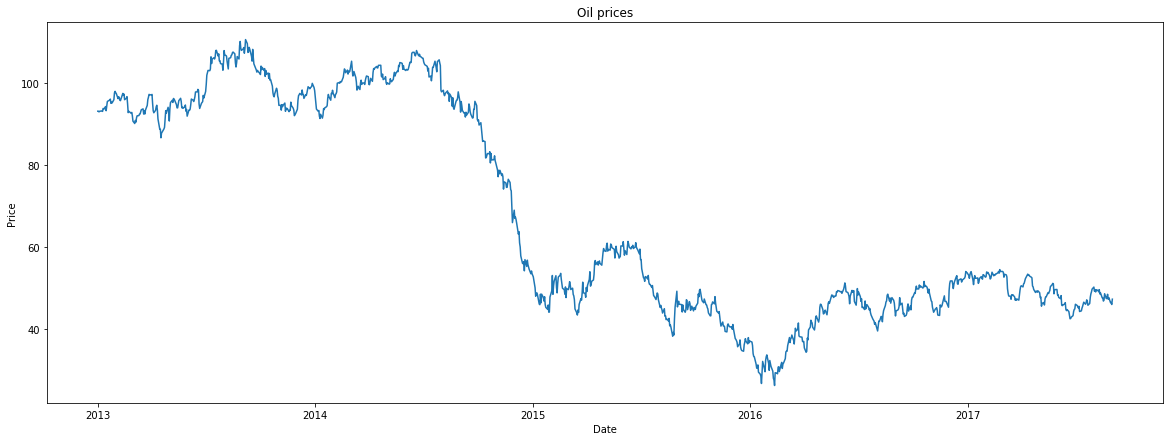

In [16]:
oil_df['date'] = pd.to_datetime(oil_df['date'])
oil_dates = [d.to_pydatetime() for d in oil_df.date]

plt.figure(figsize=(20,7))
plt.plot(oil_dates, oil_df.dcoilwtico)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Oil prices")
plt.show()


2014 saw a mojor drop in the oil prices. But what effect would that have had ?

In [34]:
grouped_trans = transactions_df.groupby('date')['transactions'].agg(np.sum)
#pd.DataFrame((data=grouped_trans, index=grouped_trans.index, columns=['date','total_transactions'])

grouped_trans_df = pd.DataFrame({'date':grouped_trans.index, 'total_transactions':grouped_trans.values})
ax = sns.barplot(x="date", y="total_transactions", data=grouped_trans_df)
ax

## Creating datasets for different models

I am now at another key point. I will now create new datasets that incorporate the engineered features. 

**TODO - dont run this code**

In [15]:
train_df = train_df.merge(stores_df, on='store_nbr', how='left')
train_df = train_df.merge(items_df, on='item_nbr', how='left')

print("The number of entries in the training set are: %d" % len(train_df))
print("The number of columns in the training set are: %d" % len(train_df.columns.values))


KeyboardInterrupt: 

In [14]:
nn_train_df = train_df.pivot(index='date', columns=['store_nbr','item_nbr'], values='unit_sales')



ValueError: Index contains duplicate entries, cannot reshape